# GRT Development

This notebook develops some of the key ideas and tools of the new version of GRT

In [1]:
import spiceypy as spy
from matplotlib import pyplot as plt
import pandas as pd
from time import time,strftime
import numpy as np
%matplotlib nbagg
TIME=time()

import tarfile

BDIR=f"./"
DATADIR=f"{BDIR}/data/"
KERDIR=f"{BDIR}/util/kernels/"
FIGDIR=f"{BDIR}/papers/paper1/figures/"

In [2]:
%matplotlib nbagg

## Constants

In [419]:
MUSUN*1e3**3

1.32712440040944e+20

In [88]:
#Numerical
DEG=np.pi/180
RAD=1/DEG

#Phsyical
ELEV=80.0 #km, Reference elevation
AU=1.4959787070000000e8 #km, value assumed in DE430
RMOON=3.84e5 #km

#Source: DE421
#https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421_announcement.pdf
MUSUN=132712440040.944000 #km^3/s^2
MUEARTH=398600.436233 #km^3/s^2
MUMOON=4902.800076 #km^3/s^2
MUEARTHMOON=403503.236310 #km^3/s^2
RHILLEARTH=AU*(MUEARTH/(3*MUSUN))**(1./3)
RHILLMOON=RMOON*(MUMOON/(3*MUEARTH))**(1./3)

#Time constants
DAY=86400
YEAR=365.24*DAY

#Body reference frames

#Kernels
kernels=[
    #Time
    "naif0012.tls",
    #Object properties
    "pck00010.tpc",
    #Planetary positions
    #"de421.bsp",
    "de430.bsp",
    #Earth reference system
    #"earth_720101_070426.bpc","earth_070425_370426_predict.bpc","earth_latest_high_prec_20190910.bpc"
    "earth_latest_high_prec_20161205.bpc",
    "moon_pa_de421_1900-2050.bpc",
    "moon_080317.tf"
    ]
for kernel in kernels:spy.furnsh(f"{KERDIR}/{kernel}")

## Routines

In [376]:
def medHistogram(data,**args):
    h,x=np.histogram(data,**args)
    xm=(x[1:]+x[:-1])/2
    return h,xm

def elTime(verbose=True):
    global TIME
    t=time()
    dt=t-TIME
    if verbose:print("%.3f s, %.3f min, %g h"%(dt,dt/60.0,dt/3600.0))
    TIME=t

def str2t(date):
    et=spy.str2et(date)
    dt=spy.deltet(et,"ET")
    t=et-dt
    return t
spy.str2t=str2t

class Angle(object):
    """
    Routines related to angles
    """
    def dms(value):
        """
        Parameters:
            dec: Angle in decimal, float, degree
        Return:
            dms: Angle in dms, tuple/list/array(4), (sign,deg,min,sec)
        """
        sgn=np.sign(value)
        val=np.abs(value)
        deg=np.floor(val)
        rem=(val-deg)*60
        min=np.floor(rem)
        sec=(rem-min)*60
        return (sgn,deg,min,sec)
    def dec(dms):
        """
        Parameters:
            dms: Angle in dms, tuple/list/array(4), (sign,deg,min,sec)
        Return:
            dec: Angle in decimal, float, degree
        """
        return dms[0]*(dms[1]+dms[2]/60.0+dms[3]/3600.0)
    

    
def zappalaDistance(E1,E2):
    """                                                                                                                                                                              
    Zappala (1990), Nervorny & Vokrouhlicky (2006)                                                                                                                                   
    am=(a+at)/2                                                                                                                                                                      
    d2c=1/np.sqrt(am)*(ka*((at-a)/am)**2+ke*(et-e)**2+ki*(sinit-np.sin(i*DEG))**2+kO*(Omega-Ot)**2+kw*(omega-ot)**2)
    Parameters:
        E1: Elements 1, np.array(5), [q(UL),e,i(rad),W(rad),w(rad)]
        E2: Elements 1, np.array(5), [q(UL),e,i(rad),W(rad),w(rad)]
    Return:
        DZ: Zappala distance (when [q]=AU, DZ<0.1 is a good match), float
    """
    #Coefficients
    ka=5./4
    ke=ki=2
    kw=kW=1e-4
    #Elements
    q1,e1,i1,W1,w1=E1[:5]
    q2,e2,i2,W2,w2=E2[:5]
    #Derived elements
    sini1=np.sin(i1)
    sini2=np.sin(i2)
    a1=np.abs(q1/(1-e1))
    a2=np.abs(q2/(1-e2))
    am=(a1+a2)/2
    anm=1/np.sqrt(np.abs(am))
    varpi1=W1+w1
    varpi2=W2+w2
    """
    print("Reference:",E1[:5])
    print("Comparison:",E2[:5])
    print(f"Derived reference: a={a1:g},sini={sini1:g},varpi={varpi1:g}")
    print(f"Derived comparison: a={a2:g},sini={sini2:g},varpi={varpi2:g}")
    print(f"Average: am={am:g},1/sqrt(am)={anm:g}")
    #"""
    #Zappala metric (Zuluaga & Sucerquia, 2018)
    DZ=anm*(ka*(a1-am)**2/am**2+ke*(e1-e2)**2+ki*(sini1-sini2)**2+kW*(W1-W2)**2+kw*(varpi1-varpi2)**2)**0.5

    return DZ

from copy import deepcopy
GLOBAL_OBS=None
def rayOscelt(lon,lat,alt,objid,A,h,vimp,et,rSoI=1e6,simple=True):
    """
    Compute the orbital elements of a particle impacting on lon, lat, alt at time et
    going towards A, h at speed vimp.
    
    Parameters:
        lon: Longitude, float, degrees
        lat: Latitude, float, degrees
        alt: Altitude, float, km
        A: Azimuth, float, degrees
        h: Elevation, float, degrees
        vimp: Impact speed, float (negative), km/s
    """
    #Prepare observer structure
    global GLOBAL_OBS
    if (GLOBAL_OBS is None) or \
            np.isclose([lon,lat,alt],[GLOBAL_OBS.lon*RAD,GLOBAL_OBS.lat*RAD,GLOBAL_OBS.alt],rtol=1e-5).sum()<3:
        #print("New observer")
        obs=Observer(lon*DEG,lat*DEG,alt,objid)
        obs._RP=obs._RE;obs._calcMatrices() #Correction for error in GravRay
        obs.updateOrientationPosition(et)
        GLOBAL_OBS=deepcopy(obs)
    else:
        #print("Old observer")
        obs=GLOBAL_OBS
        if np.isclose(et,GLOBAL_OBS._et,rtol=1e-10)==False:
            #print("New time")
            obs.updateOrientationPosition(et)
            
    #Simple estimation
    if simple:
        heliostate=obs.helioState(A*DEG,h*DEG,vimp)
        E_sim=spy.oscelt(heliostate,et,MUSUN)
    #Geocentric conic:
    bodyState=obs.bodyState(A*DEG,h*DEG,vimp)
    rt=spy.vnorm(bodyState[:3])
    q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(bodyState,et,MUEARTH)
    a=q/(1-e)
    n=np.sqrt(MUEARTH/np.abs(a)**3)
    etp=eto-Mo/n
    #SoI:
    fd=np.arccos((q*(1+e)/rSoI-1)/e)
    #See: https://space.stackexchange.com/questions/27602/what-is-hyperbolic-eccentric-anomaly-f
    Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
    Md=e*np.sinh(Hd)-Hd
    deltat=Md/n
    #Heliocentric conic:
    earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
    bodyStatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
    soipos=bodyStatet+earthpos
    E_pcon=spy.oscelt(soipos,etp+deltat,MUSUN)
    if simple:
        return E_sim,E_pcon 
    else:
        return E_pcon 


In [350]:
class Observer(object):
    """
    lon: longitude, float, radians
    lat: latitude, float, radians
    alt: elevation over reference ellipsoid, float, km
    objid: SPICE Object string (eg. EARTH), string
    """
    _RF=dict(
        EARTH="ITRF93",
        MOON="IAU_MOON" #Others: MOON_PA, MOON_ME
    )
    _PROT=dict(EARTH=DAY,MOON=27.321661*DAY)
    
    def __init__(self,lon,lat,alt,objid):
        self.lon=lon
        self.lat=lat
        self.alt=alt
        self.objid=objid
        radii=spy.bodvrd(self.objid,"RADII",3)[1]
        self._RE=radii[0]
        self._RP=radii[2]
        self._FE=(self._RE-self._RP)/self._RE
        self._positionBody=spy.georec(lon,lat,alt,self._RE,self._FE) 
        self._rho=((self._positionBody[:2]**2).sum())**0.5 #Distance to Earth's axis
        #Minus sign is because local reference frame is: x=North, y=West, z=Up
        #ERROR: This is probably a mistake
        self._velocityLocal=np.array([0,-2*np.pi*self._rho/self._PROT[self.objid],0]) 
        #This is the correct sign (use only in the production code)
        #self._velocityLocal=np.array([0,+2*np.pi*self._rho/self._PROT[self.objid],0]) 
        self._calcMatrices()
        self._velocityBody=spy.mxv(self._loc2bod,self._velocityLocal)
    
    def _calcMatrices(self):
        uz=spy.surfnm(self._RE,self._RE,self._RP,self._positionBody)
        uy=spy.ucrss(np.array([0,0,1]),uz)
        ux=spy.ucrss(uz,uy)
        self._loc2bod=np.array(np.vstack((ux,uy,uz)).transpose().tolist())
        self._bod2loc=np.linalg.inv(self._loc2bod)
        self._bod2ecl=None
        self._ecl2bod=None
        
    def updateOrientationPosition(self,et):
        self._et=et
        self._bod2ecl=spy.pxform(self._RF[self.objid],"ECLIPJ2000",et)
        self._ecl2bod=np.linalg.inv(self._bod2ecl)
        self._stateBody=spy.spkezr(self.objid,et,"ECLIPJ2000","NONE","SSB")[0]
        self._positionEcl=spy.mxv(self._bod2ecl,self._positionBody)
        self._positionEcl=self._positionEcl+self._stateBody[:3]
        
    def _checkOrientation(self):
        if self._ecl2bod is None:
            raise AssertionError("You must update orientation, eg. observer.updateOrientation(et)")
        
    def ecl2loc(self,eclon,eclat):
        """
        Parameters:
            eclon: Ecliptic longitude, float, radians
            eclat: Ecliptic latitude, float, radians
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        """
        self._checkOrientation()
        ecx,ecy,ecz=spy.latrec(1,eclon,eclat)
        x,y,z=spy.mxv(self._bod2loc,spy.mxv(self._ecl2bod,[ecx,ecy,ecz]))
        r,A,h=spy.reclat([x,y,z])
        A=2*np.pi+A if A<0 else A
        return A,h

    def loc2ecl(self,A,h):
        """
        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        Return:
            eclon: Ecliptic longitude (0,2pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
        """
        self._checkOrientation()
        x,y,z=spy.latrec(1,A,h)
        ecx,ecy,ecz=spy.mxv(self._bod2ecl,spy.mxv(self._loc2bod,[x,y,z]))
        r,eclon,eclat=spy.reclat([ecx,ecy,ecz])
        eclon=2*np.pi+eclon if eclon<0 else eclon
        return eclon,eclat

    def vBod2vloc(self,vBod):
        """
        Parameters:
            vBod: Velocity in the body-fixed system, np.array, km/s
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        """
        vLoc=spy.mxv(self._bod2loc,vBod)
        vloc,A,h=spy.reclat(vLoc)
        A=2*np.pi+A if A<0 else A
        return A,h,vloc
    
    def vloc2vBod(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the rotating geocentric reference frame) 
        of a particle GOING to A,h at a speed vloc. 
        
        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vBod: Velocity in the body-fixed system, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)
        vBod=spy.mxv(self._loc2bod,vLoc)
        return vBod
    
    def vloc2vRot(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the non-rotating geocentric reference frame) 
        of a particle GOING from A,h at a speed vloc

        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vRot: Velocity in the inertial system, body axes, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)+self._velocityLocal
        vRot=spy.mxv(self._loc2bod,vLoc)
        return vRot
        
    def vloc2vEcl(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the heliocentric reference frame) 
        of a particle GOING from A,h to a speed vloc

        It is VERY importante to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc) or (360-A,h,vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vEcl: Velocity in the inertial ecliptic system, np.array, km/s
        """
        vRot=self.vloc2vRot(A,h,vloc)
        vEcl=spy.mxv(self._bod2ecl,vRot)+self._stateBody[3:]
        return vEcl

    def helioState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            bodyState: State vector with respect to sun, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        vEcl=self.vloc2vEcl(A,h,vloc)
        state=np.concatenate((self._positionEcl,vEcl))
        return state

    def bodyState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            bodyState: State vector with respect to geocenter, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        return self.helioState(A,h,vloc)-self._stateBody

    
    def vecl2vEcl(self,eclon,eclat,vloc):
        """
        Parameters:
            eclon: Ecliptic longitude (0,2 pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (0,infty), float, km/s
        Return:
            vEcl: Velocity in the ecliptic system, np.array, km/s
        """
        self._checkOrientation()
        A,h=self.ecl2loc(eclon,eclat)
        vEcl=self.vloc2vEcl(vloc,A,h)
        return vEcl

## Data Reading

In [413]:
fname=f"{BDIR}/../grt-YearTestMoon.data"
data=np.loadtxt(fname)
columns=["h","Az","vimp","xobs","yobs","zobs","vxobs","vyobs","vzobs","q","e","i","Omega","omega","M","qapex"]
data=pd.DataFrame(data,columns=columns)
data["ET"]=86400
data["lat"]=4.11274e+01
data["lon"]=4.56452e+01
data.describe()

,h,Az,vimp,xobs,yobs,zobs,vxobs,vyobs,vzobs,q,e,i,Omega,omega,M,qapex,ET,lat,lon
count,240.000000,240.000000,240.000000,2.400000e+02,2.400000e+02,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0000,2.400000e+02
mean,27.888800,140.570933,24.262070,-3.036576e+07,1.434527e+08,6.585296e+04,-23.830851,-13.021597,-8.143034,0.616244,0.934123,31.889037,236.156666,179.616384,-4.431282,102.619161,86400.0,41.1274,4.564520e+01
std,18.220802,103.557705,12.040894,7.839459e-08,4.479691e-07,1.604056e-10,15.174671,13.093465,14.169102,0.305585,0.816743,27.179612,78.704675,104.648540,466.431282,37.104474,0.0,0.0000,1.708866e-13
min,6.603600,1.650200,4.466000,-3.036576e+07,1.434527e+08,6.585296e+04,-64.497246,-43.258001,-42.524380,0.028893,0.043644,0.269588,98.513614,0.121733,-2466.732658,33.034627,86400.0,41.1274,4.564520e+01
25%,12.875500,61.096250,14.364000,-3.036576e+07,1.434527e+08,6.585296e+04,-33.573665,-20.596194,-17.570737,0.338888,0.420495,11.291967,102.104709,113.476647,-5.768528,77.277302,86400.0,41.1274,4.564520e+01
50%,22.713000,124.235000,24.262000,-3.036576e+07,1.434527e+08,6.585296e+04,-24.409549,-12.154735,-7.532605,0.705219,0.694832,25.111684,281.609922,162.866523,118.217165,107.673243,86400.0,41.1274,4.564520e+01
75%,42.944250,205.677500,34.160000,-3.036576e+07,1.434527e+08,6.585296e+04,-13.529866,-6.566759,-0.309185,0.903038,1.041101,43.921666,281.973542,275.779525,263.276926,130.643238,86400.0,41.1274,4.564520e+01
max,62.009000,340.080000,44.058000,-3.036576e+07,1.434527e+08,6.585296e+04,13.633496,15.018812,27.897640,0.995276,4.516977,136.342493,296.953673,355.365028,357.761784,161.802333,86400.0,41.1274,4.564520e+01


In [414]:
iev=100
event=data.iloc[iev]
obs=Observer(event["lon"]*DEG,event["lat"]*DEG,10.0,"MOON")
obs.updateOrientationPosition(event["ET"])
event["lat"],event["lon"],event["Az"],event["h"],event["vimp"],event["ET"],spy.et2utc(event["ET"],"C",0)

(41.1274, 45.6452, 1.6502, 56.981, 4.466, 86400.0, '2000 JAN 02 11:58:56')

In [333]:
#Comparison
opt=(event["Az"])*DEG,event["h"]*DEG,-event["vimp"]
#opt=(360-event["Az"])*DEG,-event["h"]*DEG,event["vimp"]
obs._positionEcl,obs.vloc2vEcl(*opt),\
event[["xobs","yobs","zobs"]].values,event[["vxobs","vyobs","vzobs"]].values

(array([-3.03657568e+07,  1.43452692e+08,  6.58529629e+04]),
 array([-28.58080454,  -7.71067586,  -4.33760638]),
 array([-3.03657568e+07,  1.43452692e+08,  6.58529629e+04]),
 array([-28.58080454,  -7.71067586,  -4.33760638]))

In [11]:
Angle.dms(event["lat"]),Angle.dms(event["lon"])

((1.0, 41.0, 7.0, 38.64000000000544), (1.0, 45.0, 38.0, 42.72000000000958))

In [12]:
#Test position in the sky of Jupiter
eclon=25.3157371
eclat=-1.2593327
A,h=obs.ecl2loc(eclon*DEG,eclat*DEG)
A*RAD,h*RAD,Angle.dms(A*RAD),Angle.dms(h*RAD),Angle.dms(255.7181),Angle.dms(11.6614) #Horizons NASA

(255.71124925564067,
 11.668502463518497,
 (1.0, 255.0, 42.0, 40.49732030639916),
 (1.0, 11.0, 40.0, 6.608868666587853),
 (1.0, 255.0, 43.0, 5.159999999973479),
 (1.0, 11.0, 39.0, 41.040000000001555))

In [13]:
#Test position in the sky
A=229.2705
h=28.8062
eclon,eclat=obs.loc2ecl(A*DEG,h*DEG)
eclon*RAD,eclat*RAD,Angle.dms(eclon*RAD),Angle.dms(eclat*RAD),Angle.dms(55.1580499),Angle.dms(-5.0588748) #Horizons NASA

(55.14827427547071,
 -5.058802864839488,
 (1.0, 55.0, 8.0, 53.78739169456253),
 (-1.0, 5.0, 3.0, 31.69031342215696),
 (1.0, 55.0, 9.0, 28.97964000000627),
 (-1.0, 5.0, 3.0, 31.949279999999618))

In [202]:
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

q=0.9369969255779982 AU,e=0.043644234208226565,i=6.642858084856535,W=282.68973546206416,w=278.6187076890909
M=254.0570472501382,a=0.9797577001088629 AU


In [203]:
#Simply determined
heliostate=obs.helioState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(heliostate,event["ET"],MUSUN)
print(f"q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")

q=0.9157429901259455 AU,e=0.05546623496235629,i=8.347154252753898,W=282.12719618580036,w=284.34681726132453
M=261.6905588214188,f=255.4759298603374,a=0.9695185328704996 AU,P=0.9546721770196913 yr


## Patched conics determination

Here we will attempt to determine the orbital elements using a patched conics determination

### Moon+geo

In [253]:
#Moon-centered orbit
bodystate=obs.bodyState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
print(bodystate)
rt=spy.vnorm(bodystate[:3])
q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(bodystate,event["ET"],MUMOON)
a=q/(1-e)
n=np.sqrt(MUMOON/np.abs(a)**3)
etp=eto-Mo/n
print(f"q={q/obs._RE} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={Mo*RAD},\
f={f*RAD},a={a/obs._RE} AU, n={n} rad/s,\nr = {rt} km, tp = {etp} s")

[-1.89857046e+02  1.28796481e+03  1.16555039e+03  3.21996982e-01
 -1.13500888e+00 -4.30740433e+00]
q=0.47895130343059333 AU,e=3.432865455360587,i=92.68521671744234,W=275.9790084059429,w=209.22356088849344
M=-221.95857226221077,f=246.96871260361533,a=-0.19686715612458955 AU, n=0.011069103921554049 rad/s,
r = 1747.400000010071 km, tp = 86749.97484136526 s


In [254]:
#Propagate until RHM
r=384000*(MUMOON/(3*MUEARTH))**(1./3)
fd=np.arccos((q*(1+e)/r-1)/e)
Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
Md=e*np.sinh(Hd)-Hd
deltat=Md/n
print(f"r = {r} km, f={fd*RAD},H={Hd*RAD},M={Md*RAD},deltat={deltat} s")

r = 61460.054961310416 km, f=105.89161261391693,H=266.79408402001167,M=10084.015728997478,deltat=15900.047333659217 s


In [255]:
#State vector at hill radius
bodystatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUMOON],etp-deltat)
print(bodystatet)
spy.vnorm(bodystatet[:3])

[-4.26272349e+03  1.38032838e+04  5.97380691e+04  2.57734831e-01
 -7.87842722e-01 -3.71571567e+00]


61460.0549613104

In [257]:
moonpos=spy.spkezr("MOON",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
print(moonpos,etp-deltat)
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(bodystatet+moonpos,etp-deltat,MUSUN)
print(f"q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"Numerical: q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

[-2.99158084e+07  1.43553166e+08  6.51317071e+04 -2.89438288e+01
 -6.51244423e+00 -2.69333041e-02] 70849.92750770604
q=0.9197874453778818 AU,e=0.046433986150209085,i=7.211064432629331,W=282.1578063511331,w=292.64263012846857
M=251.93154808996692,f=246.96871260361533,a=0.9645765809799196 AU,P=0.9473820740432116 yr
Numerical: q=0.9369969255779982 AU,e=0.043644234208226565,i=6.642858084856535,W=282.68973546206416,w=278.6187076890909
M=254.0570472501382,a=0.9797577001088629 AU


In [226]:
#Geo Position
moonpos=spy.spkezr("MOON",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
geostate=(bodystatet+moonpos)-earthpos

In [227]:
#Geo orbit
eto=etp-deltat
rt=spy.vnorm(geostate[:3])
q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,eto,MUEARTH)
a=q/(1-e)
n=np.sqrt(MUEARTH/np.abs(a)**3)
etp=eto-Mo/n
print(f"q={q/obs._RE} RE,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={Mo*RAD},\
f={f*RAD},a={a/obs._RE} RE, n={n} rad/s,\nr = {rt} km, tp = {etp} s")

q=232.1601741184112 RE,e=16.192853450552825,i=66.7549170838891,W=57.34763422817943,w=171.7128149204201
M=-92.0200056883416,f=246.96871260361533,a=-15.280880242411838 RE, n=0.00014594748007266766 rad/s,
r = 405749.8811077541 km, tp = 81854.24273237326 s


In [228]:
#Earth Hill-sphere
r=1e6
fd=np.arccos((q*(1+e)/r-1)/e)
Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
Md=e*np.sinh(Hd)-Hd
deltat=Md/n
geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
print(f"f={fd*RAD},H={Hd*RAD},M={Md*RAD},deltat={deltat} s")

f=68.49952753071506,H=86.88882039185472,M=1924.89200673237,deltat=230190.3619444016 s


In [229]:
#Patched conics
earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
soipos=geostatet+earthpos
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(soipos,etp-deltat,MUSUN)
print(f"Patched Conics: q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"Numerical: q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

Patched Conics: q=0.9278622334593476 AU,e=0.046416326807781134,i=6.87587782968895,W=282.22718391522164,w=281.4119483402276
M=260.76938882076723,f=255.57489115677922,a=0.9730265518842551 AU,P=0.9598583116554641 yr
Numerical: q=0.9369969255779982 AU,e=0.043644234208226565,i=6.642858084856535,W=282.68973546206416,w=278.6187076890909
M=254.0570472501382,a=0.9797577001088629 AU


### Only Geo

In [24]:
#Moon-centered orbit
moonpos=spy.spkezr("MOON",eto,"ECLIPJ2000","NONE","SSB")[0]
earthpos=spy.spkezr("EARTH",eto,"ECLIPJ2000","NONE","SSB")[0]
bodystate=obs.bodyState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
geostate=(bodystate+moonpos)-earthpos

In [25]:
rt=spy.vnorm(geostate[:3])
q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,event["ET"],MUEARTH)
a=q/(1-e)
n=np.sqrt(MUEARTH/np.abs(a)**3)
etp=eto-Mo/n
print(f"q={q/obs._RE} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={Mo*RAD},\
f={f*RAD},a={a/obs._RE} AU, n={n} rad/s,\nr = {rt} km, tp = {etp} s")

r=1e6
fd=np.arccos((q*(1+e)/r-1)/e)
Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
Md=e*np.sinh(Hd)-Hd
deltat=Md/n

geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)

#Patched conics
earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
soipos=geostatet+earthpos
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(soipos,etp+deltat,MUSUN)
print(f"Patched Conics: q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"Numerical: q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

q=231.65451322094643 AU,e=22.207267609460626,i=66.54951514359514,W=55.231022786363134,w=170.0962969630628
M=87.61518637862835,f=255.57489115677922,a=-10.923355025595312 AU, n=0.00024148217864864409 rad/s,
r = 403570.67467764666 km, tp = 80067.55142920715 s
Patched Conics: q=0.9242436673918892 AU,e=0.0574457483843796,i=8.017086874131467,W=282.17873112405607,w=272.72273864287814
M=271.26247805880564,f=264.68532663120396,a=0.9805734426508127 AU,P=0.9710470719753568 yr
Numerical: q=0.9369969255779982 AU,e=0.043644234208226565,i=6.642858084856535,W=282.68973546206416,w=278.6187076890909
M=254.0570472501382,a=0.9797577001088629 AU


## General routine

In [379]:
from copy import deepcopy
GLOBAL_OBS=None
def rayOscelt(lon,lat,alt,objid,A,h,vimp,et,objects=["EARTH"],mus=[MUEARTH],rhill=[1e6],simple=True):
    """
    Compute the orbital elements of a particle impacting on lon, lat, alt at time et
    going towards A, h at speed vimp.
    
    Parameters:
        lon: Longitude, float, degrees
        lat: Latitude, float, degrees
        alt: Altitude, float, km
        A: Azimuth, float, degrees
        h: Elevation, float, degrees
        vimp: Impact speed, float (negative), km/s
    """
    #Prepare observer structure
    global GLOBAL_OBS
    if (GLOBAL_OBS is None) or \
            np.isclose([lon,lat,alt],[GLOBAL_OBS.lon*RAD,GLOBAL_OBS.lat*RAD,GLOBAL_OBS.alt],rtol=1e-5).sum()<3:
        #print("New observer")
        obs=Observer(lon*DEG,lat*DEG,alt,objid)
        obs._RP=obs._RE;obs._calcMatrices() #Correction for error in GravRay
        obs.updateOrientationPosition(et)
        GLOBAL_OBS=deepcopy(obs)
    else:
        #print("Old observer")
        obs=GLOBAL_OBS
        if np.isclose(et,GLOBAL_OBS._et,rtol=1e-10)==False:
            #print("New time")
            obs.updateOrientationPosition(et)
            
    #Simple estimation
    if simple:
        heliostate=obs.helioState(A*DEG,h*DEG,vimp)
        E_sim=spy.oscelt(heliostate,et,MUSUN)
    
    E_pcon=[]

    #State respect to the central body
    state=obs.bodyState(A*DEG,h*DEG,vimp)+obs._stateBody
    for k,objid in enumerate(objects):
        #print(objid)
        #State respect to object objid
        bodypos=spy.spkezr(objid,et,"ECLIPJ2000","NONE","SSB")[0]
        state=state-bodypos
        #Get object-centric elements
        rt=spy.vnorm(state[:3])
        q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(state,et,mus[k])
        a=q/(1-e)
        n=np.sqrt(mu/np.abs(a)**3)
        etp=eto-Mo/n
        #hill
        fd=np.arccos((q*(1+e)/rhill[k]-1)/e)
        #See: https://space.stackexchange.com/questions/27602/what-is-hyperbolic-eccentric-anomaly-f
        Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
        Md=e*np.sinh(Hd)-Hd
        deltat=Md/n
        #Body position
        bodypos=spy.spkezr(objid,etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
        #Heliocentric conic:
        bodyStatet=spy.conics([q,e,i,Omega,omega,Mo,eto,mus[k]],etp-deltat)
        hillstate=bodyStatet+bodypos
        #Final orbit
        E_pcon+=[spy.oscelt(hillstate,etp-deltat,MUSUN)]
        #Next state
        et=etp-deltat
        state=hillstate
        #break
    if simple:
        return E_sim,E_pcon 
    else:
        return E_pcon 

In [415]:
et=spy.str2t("2000 JAN 02 12:00:00 UTC")
objects=["MOON","EARTH"]
Esim,Epcon=rayOscelt(45.6452,41.1274,10.0,"MOON",1.6502,56.981,-4.466,et,
                     objects=objects,mus=[MUMOON,MUEARTH],rhill=[6e4,1e6])
Esim[0]/=AU;Esim[2:5]*=RAD
q,e,i,W,w=Esim[:5]
print(f"Determined simple:q={q:.5g},e={e:.5g},i={i:.5g},W={W:.5g},w={w:.5g},a={q/(1-e):.5g} AU")
for i,objid in enumerate(objects):
    Ep=Epcon[i]
    Ep[0]/=AU;Ep[2:5]*=RAD
    q,e,i,W,w=Ep[:5]
    print(f"Determined using {objid}:q={q:.5g},e={e:.5g},i={i:.5g},W={W:.5g},w={w:.5g},a={q/(1-e):.5g} AU")
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"Numerical: q={q:.5g} AU,e={e:.5g},i={i},W={Omega:.5g},w={omega:.5g},a={q/(1-e)} AU")

Determined simple:q=0.91574,e=0.055466,i=8.3472,W=282.13,w=284.35,a=0.96952 AU
Determined using MOON:q=0.91975,e=0.046434,i=7.2123,W=282.16,w=292.7,a=0.96454 AU
Determined using EARTH:q=0.92786,e=0.046419,i=6.8766,W=282.23,w=281.41,a=0.97303 AU
Numerical: q=0.937 AU,e=0.043644,i=6.642858084856535,W=282.69,w=278.62,a=0.9797577001088629 AU


In [368]:
%timeit -n 1000 rayOscelt(45.6452,41.1274,10.0,"MOON",1.6502,56.981,-4.466,et,objects=objects,mus=[MUMOON,MUEARTH],rhill=[6e4,1e6])

1000 loops, best of 3: 828 µs per loop


In [369]:
et=spy.str2t("02/15/2013 03:20:34 UTC")
Esim,Epcon=rayOscelt(63.5,54.4,70.0,"EARTH",96.0,17.0,-19.0,et)
Epcon=Epcon[0]
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(f"q={q:.5g} AU,e={e:.5g},i={i:.5g},W={W:.5g},w={w:.5g},a={q/(1-e):.5g} AU")

q=0.77851 AU,e=0.66251,i=5.0629,W=326.57,w=118.01,a=2.3067 AU


In [370]:
et=spy.str2t("02/15/2013 03:20:34 UTC")
Esim,Epcon=rayOscelt(Angle.dec((1,61,22,33)),Angle.dec((1,55,9,17)),100.0,"EARTH",99.9,15.2,-18.6,et)
Epcon=Epcon[0]
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(f"q={q:.5g} AU,e={e:.5g},i={i:.5g},W={W:.5g},w={w:.5g},a={q/(1-e):.5g} AU")

q=0.74445 AU,e=0.59329,i=4.0402,W=326.57,w=109.86,a=1.8304 AU


In [371]:
et=spy.str2t("2000 FEB 20 12:00:00 UTC")
Esim,Epcon=rayOscelt(-29.9483,-16.4228,80.0,"EARTH",1.6502,56.981,-12.207,et)
Epcon=Epcon[0]
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(f"q={q:.5g} AU,e={e:.5g},i={i:.5g},W={W:.5g},w={w:.5g},a={q/(1-e):.5g} AU")
#Compare with: q=0.860057 AU,e=0.129409381,i=7.4509,W=331.69987,w=78.8987

q=0.85637 AU,e=0.12978,i=7.558,W=331.69,w=78.436,a=0.98408 AU


In [373]:
%timeit -n 1000 rayOscelt(-29.9483,-16.4228,80.0,"EARTH",1.6502,56.981,-12.207,et)

1000 loops, best of 3: 679 µs per loop


## Tests

In [311]:
import unittest
class Test(unittest.TestCase):
    
    #Zero-observer
    et=spy.str2et("2000 JAN 01 12:00:00 UTC")
    observer=Observer(0*DEG,0*DEG,0,"EARTH")
    observer.updateOrientationPosition(et)

    #Chelyabinsk impact
    etchely=spy.str2et("02/15/2013 3:20:34 UTC")
    chely=Observer(61.1*DEG,54.8*DEG,23.3,"EARTH")
    chely.updateOrientationPosition(etchely)
    
    #Arbitrary impact
    etarb=4320000.0 #Feb. 20/2000, 12:00:00 TDB
    arb=Observer(-29.9483*DEG,-16.4228*DEG,80.0,"EARTH")
    arb._RP=arb._RE;arb._calcMatrices() #Error in GravRay
    arb.updateOrientationPosition(etarb)
    
    #Moon impact
    etmoon=spy.str2et("2000 JAN 02 11:58:56 UTC")
    #41.1274, 45.6452, 1.6502, 56.981, 4.466, 86400.0
    moon=Observer(45.6452*DEG,41.1274*DEG,10.0,"MOON")
    moon.updateOrientationPosition(etmoon)

    def test_mooon_observer(self):

        #State moon
        self.assertEqual(np.isclose(self.moon._stateBody,
                                    np.array([-3.03655722e+07,1.43451403e+08,6.46874070e+04,
                                              -2.89028010e+01,-6.57566772e+00,-3.02020818e-02]),
                                    rtol=1e-5).tolist(),
                         [True]*6)
        
        #Velocity
        vecl=obs.vloc2vEcl(1.6502*DEG,56.981*DEG,-4.466),
        self.assertEqual(np.isclose(vecl[0],
                                    np.array([-28.58080454,  -7.71067586,  -4.33760638]),
                                    rtol=1e-5).tolist(),
                         [True]*3)
        #Conversion
        eclon=25.3157371
        eclat=-1.2593327
        A,h=self.moon.ecl2loc(eclon*DEG,eclat*DEG)
        self.assertEqual(np.isclose([A*RAD,h*RAD],
                                    [255.7181,11.6614],
                                    atol=1e-2).tolist(),
                         [True]*2)
        A=229.2705
        h=28.8062
        eclon,eclat=obs.loc2ecl(A*DEG,h*DEG)
        self.assertEqual(np.isclose([eclon*RAD,eclat*RAD],
                                    [55.1580499,-5.0588748],
                                    atol=1e-2).tolist(),
                         [True]*2)
    
    def test_earthpos(self):
        self.assertEqual(np.isclose(self.arb._stateBody,
                                    np.array([-1.30585661e+08,7.08734759e+07,2.98745730e+04,
                                              -1.48394530e+01,-2.62057098e+01,-1.08440413e-03]),
                                    rtol=1e-5).tolist(),
                         [True]*6)
    
    def test_vrot(self):
        vrot=self.observer.vloc2vRot(90*DEG,0*DEG,10.0)
        self.assertAlmostEqual(vrot[0],0,5)
        self.assertAlmostEqual(vrot[1],9.53616882e+00,5)
        self.assertAlmostEqual(vrot[2],0,5)
        
    def test_arb_position(self):
        self.assertTrue(np.isclose(self.arb._positionEcl[0],-1.30582607e+08,rtol=1e-7,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(self.arb._positionEcl[1],7.08678075e+07,rtol=1e-7,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(self.arb._positionEcl[2],3.03545799e+04,rtol=1e-7,atol=0,equal_nan=False))
        
    def test_arb_velocity(self):
        vecl=self.arb.vloc2vEcl(1.6502*DEG,56.981*DEG,-12.207)
        self.assertTrue(np.isclose(vecl[0],-21.15990113,rtol=1e-4,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(vecl[1],-18.55669163,rtol=1e-4,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(vecl[2],-7.13767917,rtol=1e-4,atol=0,equal_nan=False))
    
    def test_et(self):
        self.assertAlmostEqual(self.et,64.2,1)
        
    def test_ellipsoid(self):
        self.assertAlmostEqual(self.observer._RE,6378.1366,4)
        self.assertAlmostEqual(self.observer._RP,6356.7519,4)
        self.assertAlmostEqual(self.observer._FE,0.0033528131084554717,7)
    
    def test_position(self):
        self.assertEqual(self.observer._positionBody[0],self.observer._RE)
        
    def test_velocity_local(self):
        self.assertAlmostEqual(self.observer._velocityLocal[0],0,5)
        self.assertAlmostEqual(self.observer._velocityLocal[1],-0.46383118,5)
        self.assertAlmostEqual(self.observer._velocityLocal[2],0,5)
        
    def test_ecl2loc_sun(self):
        #Position of the Sun
        eclon=Angle.dec((+1,280,22,21.9))
        eclat=Angle.dec((-1,0,0,2.7))
        A,h=self.observer.ecl2loc(eclon*DEG,eclat*DEG)
        self.assertAlmostEqual(A*RAD,178.07231644928592,5)
        self.assertAlmostEqual(h*RAD,66.95277694576103,5)
    
    def test_ecl2loc_Betelgeuse(self):
        #Betelgeuse
        eclon=Angle.dec((+1,88,45,16.6))
        eclat=Angle.dec((-1,16,1,37.2))
        A,h=self.observer.ecl2loc(eclon*DEG,eclat*DEG)
        self.assertAlmostEqual(A*RAD,57.27518638612843,5)
        self.assertAlmostEqual(h*RAD,-76.20677246845091,5)
    
    def test_loc2ecl_sun(self):
        A=Angle.dec((+1,57,16,30.7))
        h=Angle.dec((-1,76,12,24.4))
        eclon,eclat=self.observer.loc2ecl(A*DEG,h*DEG)
        self.assertAlmostEqual(eclon*RAD,88.75461469860417,5)
        self.assertAlmostEqual(eclat*RAD,-16.027004471139914,5)
        
    def test_chely_et(self):
        self.assertAlmostEqual(self.etchely,414170501.185,3)
        
    def test_chely_vbod2vloc(self):
        vBod=np.array([12.8,-13.3,-2.4])
        A,h,vloc=self.chely.vBod2vloc(-vBod)
        self.assertAlmostEqual(A*RAD,99.8961127649985,5)
        self.assertAlmostEqual(h*RAD,15.92414245029081,5)

    def test_chely_vloc2vbod(self):
        vBod=self.chely.vloc2vBod(279.9*DEG,-15.9*DEG,18.6)
        self.assertAlmostEqual(vBod[0],12.8,1)
        self.assertAlmostEqual(vBod[1],-13.3,1)
        self.assertAlmostEqual(vBod[2],-2.4,1)

    def test_chely_elements(self):
        et=spy.str2t("02/15/2013 03:20:34 UTC")
        Esim,Epcon=rayOscelt(63.5,54.4,80.0,"EARTH",96.0,17.0,-19.0,et)
        Epcon=Epcon[0]
        Epcon[0]/=AU;Epcon[2:5]*=RAD
        q,e,i,W,w=Epcon[:5]
        self.assertEqual(np.isclose([q,e,i,W,w],
                                    [0.78,0.66,5.07,326.57,118.00],
                                     atol=1e-1).tolist(),
                         [True]*5)
        
if __name__=='__main__':
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

................
----------------------------------------------------------------------
Ran 16 tests in 0.046s

OK


## Compare lunar elements

In [377]:
tar=tarfile.open(f"{BDIR}/../grt-YearTestMoon.tgz", "r:*")

In [383]:
from tqdm import tqdm
import random

#Read data
adata=None
ierr=0
Nsel=1000
elTime(verbose=False)
for ntar in range(len(tar.getnames())):
    print(f"Reading file {ntar}...")
    fname=tar.getnames()[ntar]
    data=np.loadtxt(tar.extractfile(fname))
    columns=["N","ET","lat","lon","h","Az","vimp",
             "xobs","yobs","zobs","vxobs","vyobs","vzobs",
             "q","e","i","Omega","omega","M","qapex"]
    data=pd.DataFrame(data,columns=columns)

    #Initialize extracolumns
    data["DZpcon_moon"]=0
    data["DZpcon_geomoon"]=0
    data["DZsim"]=0
    sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
    pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
    for i,element in enumerate(sim_elements):
        data[element]=0
        data[pcon_elements[i]]=0
        
    #Compute distances
    #for index in tqdm(data.index):
    idata=pd.DataFrame([],columns=data.columns)
    for index in tqdm(random.sample(data.index.values.tolist(),k=Nsel)):
    #for index in random.sample(data.index.values.tolist(),k=Nsel):
        event=data.loc[index]
        E_num=event[["q","e","i","Omega","omega","M"]].values
        E_num[2:]*=DEG
        E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,"MOON",event["Az"],event["h"],-event["vimp"],event["ET"],
                               objects=["MOON","EARTH"],mus=[MUMOON,MUEARTH],rhill=[6e4,1e6])
        for E in E_sim,E_pcon[0],E_pcon[1]:E[0]/=AU;
        idata.loc[index]=data.loc[index]
        idata[pcon_elements[i]]=0
        idata.loc[index,"DZpcon_moon"]=zappalaDistance(E_num,E_pcon[0])
        idata.loc[index,"DZpcon_geomoon"]=zappalaDistance(E_num,E_pcon[1])
        idata.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
        E_sim[2:]*=RAD
        E_pcon[0][2:]*=RAD
        E_pcon[1][2:]*=RAD
        for i,element in enumerate(sim_elements):
            idata.loc[index,element]=E_sim[i]
            idata.loc[index,pcon_elements[i]]=E_pcon[1][i]
    selcols=["ET","lon","lat","h","Az","vimp",
             "DZpcon_moon","DZpcon_geomoon","DZsim",
             "q","q_pcon","q_sim",
             "e","e_pcon","e_sim",
             "i","i_pcon","i_sim",
             "Omega","W_pcon","W_sim",
             "omega","w_pcon","w_sim"]
    fname=f"grtcomp-{ntar:04d}-ET{np.int(event['ET']):010d}.data"
    print(f"\tSaving {fname}...")
    nlarge=(idata["DZpcon_geomoon"]>0.1).sum()
    ierr+=nlarge
    ndata=len(idata)
    print(f"\tLarge distances: {nlarge}/{ndata}")
    print(f"\tDZ Statistics: (min,mean,std,max)={idata['DZpcon_geomoon'].min():g},{idata['DZpcon_geomoon'].mean():g},{idata['DZpcon_geomoon'].std():g},{idata['DZpcon_geomoon'].max():g}")
    np.savetxt(f"{BDIR}/../grt-YearTestMoon/{fname}",idata[selcols].values)
    if adata is None:
          adata=pd.DataFrame([],columns=idata[selcols].columns)
    adata=pd.concat((adata,idata[selcols]))
    del(data,idata)
    #if ntar>-1:break

print(f"Mismatches: {ierr}/{(ntar+1)*Nsel} = {ierr/((ntar+1.0)*Nsel)*100:g}%")
elTime(verbose=True)

Reading file 0...


100%|██████████| 1000/1000 [00:20<00:00, 68.16it/s]


	Saving grtcomp-0000-ET0000000000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000252162,0.00989411,0.0169713,0.340768
Reading file 1...


100%|██████████| 1000/1000 [00:14<00:00, 67.69it/s]


	Saving grtcomp-0001-ET0000000000.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000187618,0.0105966,0.0258163,0.436366
Reading file 2...


100%|██████████| 1000/1000 [00:14<00:00, 69.31it/s]


	Saving grtcomp-0002-ET0000086400.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000200919,0.0115694,0.0240804,0.511785
Reading file 3...


100%|██████████| 1000/1000 [00:17<00:00, 56.31it/s]


	Saving grtcomp-0003-ET0000172800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=6.84955e-05,0.0107212,0.024475,0.437932
Reading file 4...


100%|██████████| 1000/1000 [00:16<00:00, 61.54it/s]


	Saving grtcomp-0004-ET0000259200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000329411,0.010363,0.0181687,0.270342
Reading file 5...


100%|██████████| 1000/1000 [00:18<00:00, 54.90it/s]


	Saving grtcomp-0005-ET0000345600.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=5.98643e-05,0.0101725,0.0192678,0.399277
Reading file 6...


100%|██████████| 1000/1000 [00:15<00:00, 62.98it/s]


	Saving grtcomp-0006-ET0000432000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000138028,0.0107515,0.0211763,0.467662
Reading file 7...


100%|██████████| 1000/1000 [00:19<00:00, 50.06it/s]


	Saving grtcomp-0007-ET0000518400.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=9.69081e-05,0.0109179,0.0179899,0.240769
Reading file 8...


100%|██████████| 1000/1000 [00:19<00:00, 51.86it/s]


	Saving grtcomp-0008-ET0000604800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000170428,0.011154,0.017523,0.317487
Reading file 9...


100%|██████████| 1000/1000 [00:15<00:00, 63.21it/s]


	Saving grtcomp-0009-ET0000691200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000277482,0.0122195,0.0235542,0.401981
Reading file 10...


100%|██████████| 1000/1000 [00:14<00:00, 67.26it/s]


	Saving grtcomp-0010-ET0000777600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000396461,0.0116191,0.0171772,0.310514
Reading file 11...


100%|██████████| 1000/1000 [00:14<00:00, 70.57it/s]


	Saving grtcomp-0011-ET0000864000.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000454569,0.0122318,0.019413,0.341117
Reading file 12...


100%|██████████| 1000/1000 [00:18<00:00, 55.36it/s]


	Saving grtcomp-0012-ET0001036800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000505979,0.011503,0.018315,0.336814
Reading file 13...


100%|██████████| 1000/1000 [00:17<00:00, 58.43it/s]


	Saving grtcomp-0013-ET0001123200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000804525,0.0126101,0.025909,0.481927
Reading file 14...


100%|██████████| 1000/1000 [00:17<00:00, 58.77it/s]


	Saving grtcomp-0014-ET0001209600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000522892,0.011407,0.0150502,0.312842
Reading file 15...


100%|██████████| 1000/1000 [00:15<00:00, 64.05it/s]


	Saving grtcomp-0015-ET0001296000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00103281,0.0124973,0.0178126,0.301325
Reading file 16...


100%|██████████| 1000/1000 [00:17<00:00, 68.97it/s]


	Saving grtcomp-0016-ET0001382400.data...
	Large distances: 10/1000
	DZ Statistics: (min,mean,std,max)=0.000256352,0.0141672,0.023108,0.435076
Reading file 17...


100%|██████████| 1000/1000 [00:14<00:00, 67.95it/s]


	Saving grtcomp-0017-ET0001468800.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000360849,0.0135524,0.0240709,0.510315
Reading file 18...


100%|██████████| 1000/1000 [00:14<00:00, 69.66it/s]


	Saving grtcomp-0018-ET0001555200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000430749,0.0130188,0.01884,0.420546
Reading file 19...


100%|██████████| 1000/1000 [00:14<00:00, 70.59it/s]


	Saving grtcomp-0019-ET0001641600.data...
	Large distances: 11/1000
	DZ Statistics: (min,mean,std,max)=0.000324681,0.0146493,0.0300691,0.50718
Reading file 20...


100%|██████████| 1000/1000 [00:14<00:00, 67.67it/s]


	Saving grtcomp-0020-ET0001728000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000922911,0.01281,0.0143331,0.203069
Reading file 21...


100%|██████████| 1000/1000 [00:16<00:00, 68.21it/s]


	Saving grtcomp-0021-ET0001814400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000923113,0.013184,0.019701,0.456873
Reading file 22...


100%|██████████| 1000/1000 [00:18<00:00, 54.61it/s]


	Saving grtcomp-0022-ET0001900800.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00107619,0.0156009,0.0627128,1.9025
Reading file 23...


100%|██████████| 1000/1000 [00:16<00:00, 59.62it/s]


	Saving grtcomp-0023-ET0001987200.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000357913,0.0145966,0.0321404,0.836556
Reading file 24...


100%|██████████| 1000/1000 [00:17<00:00, 56.11it/s]


	Saving grtcomp-0024-ET0002073600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000852206,0.0131286,0.0182269,0.433175
Reading file 25...


100%|██████████| 1000/1000 [00:14<00:00, 72.59it/s]


	Saving grtcomp-0025-ET0002160000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000627619,0.0143867,0.022372,0.355979
Reading file 26...


100%|██████████| 1000/1000 [00:14<00:00, 68.22it/s]


	Saving grtcomp-0026-ET0002246400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000825541,0.0153434,0.0454059,1.10063
Reading file 27...


100%|██████████| 1000/1000 [00:15<00:00, 65.14it/s]


	Saving grtcomp-0027-ET0002332800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000924291,0.0138805,0.0126227,0.130912
Reading file 28...


100%|██████████| 1000/1000 [00:15<00:00, 63.48it/s]


	Saving grtcomp-0028-ET0002419200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000572734,0.0137227,0.014662,0.283642
Reading file 29...


100%|██████████| 1000/1000 [00:14<00:00, 69.41it/s]


	Saving grtcomp-0029-ET0002505600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000947685,0.014803,0.0210674,0.512065
Reading file 30...


100%|██████████| 1000/1000 [00:14<00:00, 67.49it/s]


	Saving grtcomp-0030-ET0002592000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00130644,0.0152789,0.0227461,0.520632
Reading file 31...


100%|██████████| 1000/1000 [00:14<00:00, 66.68it/s]


	Saving grtcomp-0031-ET0002678400.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00079459,0.0152276,0.0177012,0.263417
Reading file 32...


100%|██████████| 1000/1000 [00:14<00:00, 68.14it/s]


	Saving grtcomp-0032-ET0002764800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000904909,0.0146884,0.0126411,0.173423
Reading file 33...


100%|██████████| 1000/1000 [00:14<00:00, 68.01it/s]


	Saving grtcomp-0033-ET0002851200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000923991,0.0152595,0.0128983,0.187068
Reading file 34...


100%|██████████| 1000/1000 [00:16<00:00, 62.30it/s]


	Saving grtcomp-0034-ET0002937600.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000646671,0.016789,0.0314214,0.713141
Reading file 35...


100%|██████████| 1000/1000 [00:19<00:00, 52.51it/s]


	Saving grtcomp-0035-ET0003024000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000639458,0.0158573,0.015514,0.267531
Reading file 36...


100%|██████████| 1000/1000 [00:14<00:00, 68.15it/s]


	Saving grtcomp-0036-ET0003110400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000865524,0.0157401,0.0201367,0.364557
Reading file 37...


100%|██████████| 1000/1000 [00:13<00:00, 71.48it/s]


	Saving grtcomp-0037-ET0003196800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000589787,0.0166731,0.0194932,0.480424
Reading file 38...


100%|██████████| 1000/1000 [00:13<00:00, 71.90it/s]


	Saving grtcomp-0038-ET0003283200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00109454,0.0171532,0.0205856,0.432189
Reading file 39...


100%|██████████| 1000/1000 [00:13<00:00, 72.75it/s]


	Saving grtcomp-0039-ET0003369600.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000674587,0.0175433,0.0246447,0.461457
Reading file 40...


100%|██████████| 1000/1000 [00:14<00:00, 69.22it/s]


	Saving grtcomp-0040-ET0003456000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00138513,0.0171011,0.0200776,0.420356
Reading file 41...


100%|██████████| 1000/1000 [00:15<00:00, 62.78it/s]


	Saving grtcomp-0041-ET0003542400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00160882,0.0183743,0.028861,0.533773
Reading file 42...


100%|██████████| 1000/1000 [00:14<00:00, 71.30it/s]


	Saving grtcomp-0042-ET0003628800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000991575,0.0206753,0.0936524,2.87798
Reading file 43...


100%|██████████| 1000/1000 [00:14<00:00, 67.12it/s]


	Saving grtcomp-0043-ET0003715200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00075909,0.0189235,0.0505102,1.5676
Reading file 44...


100%|██████████| 1000/1000 [00:15<00:00, 64.85it/s]


	Saving grtcomp-0044-ET0003801600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00129122,0.0172244,0.0113582,0.115637
Reading file 45...


100%|██████████| 1000/1000 [00:19<00:00, 52.09it/s]


	Saving grtcomp-0045-ET0003888000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000916324,0.018422,0.015525,0.231125
Reading file 46...


100%|██████████| 1000/1000 [00:22<00:00, 45.15it/s]


	Saving grtcomp-0046-ET0003974400.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.00145099,0.0197999,0.0216899,0.353226
Reading file 47...


100%|██████████| 1000/1000 [00:19<00:00, 71.53it/s]


	Saving grtcomp-0047-ET0004060800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000562946,0.0188016,0.0311707,0.91146
Reading file 48...


100%|██████████| 1000/1000 [00:14<00:00, 69.67it/s]


	Saving grtcomp-0048-ET0004147200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00166564,0.0183194,0.0135557,0.222484
Reading file 49...


100%|██████████| 1000/1000 [00:17<00:00, 58.31it/s]


	Saving grtcomp-0049-ET0004233600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00134926,0.0187831,0.0159406,0.319533
Reading file 50...


100%|██████████| 1000/1000 [00:21<00:00, 46.86it/s]


	Saving grtcomp-0050-ET0004320000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00155787,0.0189026,0.0225671,0.616755
Reading file 51...


100%|██████████| 1000/1000 [00:21<00:00, 46.82it/s]


	Saving grtcomp-0051-ET0004406400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000747067,0.0206424,0.044826,1.22619
Reading file 52...


100%|██████████| 1000/1000 [00:19<00:00, 50.48it/s]


	Saving grtcomp-0052-ET0004492800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.0010302,0.0219827,0.037799,0.737658
Reading file 53...


100%|██████████| 1000/1000 [00:15<00:00, 63.48it/s]


	Saving grtcomp-0053-ET0004579200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.0012366,0.0193341,0.0164685,0.239627
Reading file 54...


100%|██████████| 1000/1000 [00:16<00:00, 59.89it/s]


	Saving grtcomp-0054-ET0004665600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000622813,0.0185263,0.0115248,0.201757
Reading file 55...


100%|██████████| 1000/1000 [00:15<00:00, 70.50it/s]


	Saving grtcomp-0055-ET0004752000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000924777,0.0199377,0.0287622,0.828873
Reading file 56...


100%|██████████| 1000/1000 [00:21<00:00, 46.97it/s]


	Saving grtcomp-0056-ET0004838400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00125753,0.0190542,0.0135684,0.22128
Reading file 57...


100%|██████████| 1000/1000 [00:17<00:00, 55.64it/s]


	Saving grtcomp-0057-ET0004924800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000978162,0.0189914,0.0157169,0.293841
Reading file 58...


100%|██████████| 1000/1000 [00:18<00:00, 54.71it/s]


	Saving grtcomp-0058-ET0005011200.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000989395,0.0223046,0.0467928,0.884054
Reading file 59...


100%|██████████| 1000/1000 [00:20<00:00, 48.52it/s]


	Saving grtcomp-0059-ET0005097600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000420042,0.0191827,0.0140918,0.189886
Reading file 60...


100%|██████████| 1000/1000 [00:17<00:00, 59.54it/s]


	Saving grtcomp-0060-ET0005184000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000615574,0.023008,0.070092,1.78494
Reading file 61...


100%|██████████| 1000/1000 [00:19<00:00, 58.33it/s]


	Saving grtcomp-0061-ET0005270400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00101263,0.0195018,0.0203117,0.423202
Reading file 62...


100%|██████████| 1000/1000 [00:27<00:00, 36.70it/s]


	Saving grtcomp-0062-ET0005356800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00144816,0.0191159,0.0129105,0.181627
Reading file 63...


100%|██████████| 1000/1000 [00:16<00:00, 62.86it/s]


	Saving grtcomp-0063-ET0005443200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00110362,0.0201133,0.0250288,0.675395
Reading file 64...


100%|██████████| 1000/1000 [00:18<00:00, 57.53it/s]


	Saving grtcomp-0064-ET0005529600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000722397,0.0204689,0.0248856,0.602328
Reading file 65...


100%|██████████| 1000/1000 [00:15<00:00, 63.49it/s]


	Saving grtcomp-0065-ET0005616000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000960477,0.0199282,0.0202648,0.479568
Reading file 66...


100%|██████████| 1000/1000 [00:14<00:00, 68.09it/s]


	Saving grtcomp-0066-ET0005702400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000253159,0.0199759,0.0206694,0.533066
Reading file 67...


100%|██████████| 1000/1000 [00:17<00:00, 57.34it/s]


	Saving grtcomp-0067-ET0005788800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000953546,0.0204519,0.0172906,0.31953
Reading file 68...


100%|██████████| 1000/1000 [00:21<00:00, 40.67it/s]


	Saving grtcomp-0068-ET0005875200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000728147,0.0210964,0.0213535,0.54985
Reading file 69...


100%|██████████| 1000/1000 [00:16<00:00, 68.07it/s]


	Saving grtcomp-0069-ET0005961600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00058477,0.0225513,0.0327827,0.590071
Reading file 70...


100%|██████████| 1000/1000 [00:14<00:00, 67.64it/s]


	Saving grtcomp-0070-ET0006048000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00069668,0.0210456,0.0158009,0.165829
Reading file 71...


100%|██████████| 1000/1000 [00:14<00:00, 67.18it/s]


	Saving grtcomp-0071-ET0006134400.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000733776,0.0229352,0.0191157,0.253651
Reading file 72...


100%|██████████| 1000/1000 [00:14<00:00, 68.54it/s]


	Saving grtcomp-0072-ET0006220800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000549267,0.0223705,0.0276493,0.680916
Reading file 73...


100%|██████████| 1000/1000 [00:14<00:00, 68.20it/s]


	Saving grtcomp-0073-ET0006307200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.0005179,0.0218615,0.0200457,0.482937
Reading file 74...


100%|██████████| 1000/1000 [00:14<00:00, 66.97it/s]


	Saving grtcomp-0074-ET0006393600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000848706,0.0221939,0.0154714,0.188373
Reading file 75...


100%|██████████| 1000/1000 [00:14<00:00, 68.90it/s]


	Saving grtcomp-0075-ET0006410000.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000920715,0.0238229,0.0326808,0.778212
Reading file 76...


100%|██████████| 1000/1000 [00:14<00:00, 70.05it/s]


	Saving grtcomp-0076-ET0006566400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00041482,0.0225036,0.0243842,0.552938
Reading file 77...


100%|██████████| 1000/1000 [00:14<00:00, 69.29it/s]


	Saving grtcomp-0077-ET0006652800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000474266,0.023199,0.0155405,0.130301
Reading file 78...


100%|██████████| 1000/1000 [00:14<00:00, 68.69it/s]


	Saving grtcomp-0078-ET0006739200.data...
	Large distances: 11/1000
	DZ Statistics: (min,mean,std,max)=0.000540742,0.0238014,0.0212512,0.347018
Reading file 79...


100%|██████████| 1000/1000 [00:14<00:00, 70.45it/s]


	Saving grtcomp-0079-ET0006825600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000522272,0.0230222,0.0190358,0.405167
Reading file 80...


100%|██████████| 1000/1000 [00:14<00:00, 67.48it/s]


	Saving grtcomp-0080-ET0006912000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000498429,0.0222687,0.015258,0.24671
Reading file 81...


100%|██████████| 1000/1000 [00:14<00:00, 71.10it/s]


	Saving grtcomp-0081-ET0006998400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000745426,0.023571,0.0258997,0.537887
Reading file 82...


100%|██████████| 1000/1000 [00:14<00:00, 69.88it/s]


	Saving grtcomp-0082-ET0007084800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000755462,0.0225734,0.014048,0.176644
Reading file 83...


100%|██████████| 1000/1000 [00:16<00:00, 62.05it/s]


	Saving grtcomp-0083-ET0007171200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00025566,0.0217048,0.0144186,0.185723
Reading file 84...


100%|██████████| 1000/1000 [00:14<00:00, 68.65it/s]


	Saving grtcomp-0084-ET0007257600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000526829,0.0222869,0.0150176,0.21072
Reading file 85...


100%|██████████| 1000/1000 [00:14<00:00, 69.68it/s]


	Saving grtcomp-0085-ET0007344000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00010953,0.0227536,0.0341531,1.02022
Reading file 86...


100%|██████████| 1000/1000 [00:15<00:00, 57.55it/s]


	Saving grtcomp-0086-ET0007430400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000334959,0.0237775,0.0454659,1.1823
Reading file 87...


100%|██████████| 1000/1000 [00:22<00:00, 43.74it/s]


	Saving grtcomp-0087-ET0007516800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000347487,0.0224478,0.0186203,0.334447
Reading file 88...


100%|██████████| 1000/1000 [00:16<00:00, 60.76it/s]


	Saving grtcomp-0088-ET0007603200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000127884,0.0225351,0.0222936,0.546371
Reading file 89...


100%|██████████| 1000/1000 [00:17<00:00, 58.72it/s]


	Saving grtcomp-0089-ET0007689600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000418975,0.0224279,0.0197555,0.45701
Reading file 90...


100%|██████████| 1000/1000 [00:14<00:00, 69.53it/s]


	Saving grtcomp-0090-ET0007776000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000472537,0.0212656,0.0147709,0.276164
Reading file 91...


100%|██████████| 1000/1000 [00:14<00:00, 67.29it/s]


	Saving grtcomp-0091-ET0007862400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00070166,0.0235442,0.0366328,0.746481
Reading file 92...


100%|██████████| 1000/1000 [00:15<00:00, 65.01it/s]


	Saving grtcomp-0092-ET0007948800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000332599,0.0214679,0.0231914,0.528592
Reading file 93...


100%|██████████| 1000/1000 [00:17<00:00, 58.20it/s]


	Saving grtcomp-0093-ET0008035200.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000200783,0.0226898,0.0214121,0.378537
Reading file 94...


100%|██████████| 1000/1000 [00:17<00:00, 57.98it/s]


	Saving grtcomp-0094-ET0008121600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000391711,0.0227676,0.0238403,0.563714
Reading file 95...


100%|██████████| 1000/1000 [00:19<00:00, 52.60it/s]


	Saving grtcomp-0095-ET0008208000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000353599,0.0229571,0.0290508,0.809449
Reading file 96...


100%|██████████| 1000/1000 [00:16<00:00, 59.90it/s]


	Saving grtcomp-0096-ET0008294400.data...
	Large distances: 10/1000
	DZ Statistics: (min,mean,std,max)=0.000151736,0.0247581,0.0439724,1.28016
Reading file 97...


100%|██████████| 1000/1000 [00:17<00:00, 56.69it/s]


	Saving grtcomp-0097-ET0008380800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000412242,0.0232567,0.0337743,0.74579
Reading file 98...


100%|██████████| 1000/1000 [00:26<00:00, 38.26it/s]


	Saving grtcomp-0098-ET0008467200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000480222,0.0223636,0.0220754,0.4351
Reading file 99...


100%|██████████| 1000/1000 [00:20<00:00, 49.54it/s]


	Saving grtcomp-0099-ET0008553600.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000322484,0.0240163,0.0342324,0.914911
Reading file 100...


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


	Saving grtcomp-0100-ET0008640000.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000332964,0.0250244,0.0415241,0.721062
Reading file 101...


100%|██████████| 1000/1000 [00:16<00:00, 62.07it/s]


	Saving grtcomp-0101-ET0008726400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000107531,0.0228244,0.0181633,0.303004
Reading file 102...


100%|██████████| 1000/1000 [00:14<00:00, 66.94it/s]


	Saving grtcomp-0102-ET0008812800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000587785,0.022968,0.0169755,0.337613
Reading file 103...


100%|██████████| 1000/1000 [00:14<00:00, 66.73it/s]


	Saving grtcomp-0103-ET0008899200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000403987,0.0227242,0.0161013,0.247365
Reading file 104...


100%|██████████| 1000/1000 [00:15<00:00, 65.82it/s]


	Saving grtcomp-0104-ET0008985600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000261623,0.0237864,0.0194606,0.448118
Reading file 105...


100%|██████████| 1000/1000 [00:15<00:00, 66.42it/s]


	Saving grtcomp-0105-ET0009072000.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000248529,0.0257234,0.0422902,1.0802
Reading file 106...


100%|██████████| 1000/1000 [00:16<00:00, 61.93it/s]


	Saving grtcomp-0106-ET0009158400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.0005435,0.0233678,0.0168986,0.314711
Reading file 107...


100%|██████████| 1000/1000 [00:14<00:00, 71.27it/s]


	Saving grtcomp-0107-ET0009244800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000282754,0.0232289,0.0138124,0.146338
Reading file 108...


100%|██████████| 1000/1000 [00:14<00:00, 70.28it/s]


	Saving grtcomp-0108-ET0009331200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000272477,0.0235009,0.0159421,0.238005
Reading file 109...


100%|██████████| 1000/1000 [00:14<00:00, 70.43it/s]


	Saving grtcomp-0109-ET0009417600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00061895,0.0239817,0.0418982,1.2233
Reading file 110...


100%|██████████| 1000/1000 [00:17<00:00, 56.83it/s]


	Saving grtcomp-0110-ET0009504000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000541927,0.0242298,0.0383366,1.16816
Reading file 111...


100%|██████████| 1000/1000 [00:17<00:00, 56.74it/s]


	Saving grtcomp-0111-ET0009590400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000756035,0.0227009,0.0160468,0.256881
Reading file 112...


100%|██████████| 1000/1000 [00:17<00:00, 57.65it/s]


	Saving grtcomp-0112-ET0009676800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000281161,0.0254821,0.0730974,2.12157
Reading file 113...


100%|██████████| 1000/1000 [00:17<00:00, 55.94it/s]


	Saving grtcomp-0113-ET0009763200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000657506,0.0230497,0.0260368,0.621203
Reading file 114...


100%|██████████| 1000/1000 [00:16<00:00, 56.32it/s]


	Saving grtcomp-0114-ET0009849600.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000423795,0.0245672,0.0428423,1.12147
Reading file 115...


100%|██████████| 1000/1000 [00:17<00:00, 58.74it/s]


	Saving grtcomp-0115-ET0009936000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000513125,0.0218709,0.0172005,0.403358
Reading file 116...


100%|██████████| 1000/1000 [00:17<00:00, 56.87it/s]


	Saving grtcomp-0116-ET0010022400.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000545527,0.0240886,0.0436006,1.1126
Reading file 117...


100%|██████████| 1000/1000 [00:16<00:00, 62.47it/s]


	Saving grtcomp-0117-ET0010100000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000917712,0.0221095,0.0171331,0.347279
Reading file 118...


100%|██████████| 1000/1000 [00:17<00:00, 56.60it/s]


	Saving grtcomp-0118-ET0010108800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000716394,0.0214334,0.0145014,0.174422
Reading file 119...


100%|██████████| 1000/1000 [00:17<00:00, 57.71it/s]


	Saving grtcomp-0119-ET0010195200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000848296,0.0216689,0.0186412,0.321813
Reading file 120...


100%|██████████| 1000/1000 [00:16<00:00, 59.35it/s]


	Saving grtcomp-0120-ET0010281600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000867815,0.0224612,0.027368,0.707783
Reading file 121...


100%|██████████| 1000/1000 [00:17<00:00, 58.10it/s]


	Saving grtcomp-0121-ET0010368000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00107774,0.0229924,0.0299301,0.685299
Reading file 122...


100%|██████████| 1000/1000 [00:21<00:00, 47.32it/s]


	Saving grtcomp-0122-ET0010454400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000529794,0.0205237,0.0226767,0.607262
Reading file 123...


100%|██████████| 1000/1000 [00:22<00:00, 45.33it/s]


	Saving grtcomp-0123-ET0010540800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000639634,0.0227754,0.0357375,0.741736
Reading file 124...


100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]


	Saving grtcomp-0124-ET0010627200.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.00082659,0.0216946,0.0240674,0.455292
Reading file 125...


100%|██████████| 1000/1000 [00:17<00:00, 58.46it/s]


	Saving grtcomp-0125-ET0010713600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00125924,0.0204716,0.0130603,0.200496
Reading file 126...


100%|██████████| 1000/1000 [00:17<00:00, 58.51it/s]


	Saving grtcomp-0126-ET0010886400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00082647,0.0229831,0.0347526,0.682762
Reading file 127...


100%|██████████| 1000/1000 [00:17<00:00, 61.11it/s]


	Saving grtcomp-0127-ET0010972800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00138383,0.0223713,0.0515295,1.59698
Reading file 128...


100%|██████████| 1000/1000 [00:18<00:00, 53.24it/s]


	Saving grtcomp-0128-ET0011059200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000957417,0.0212762,0.0154284,0.202272
Reading file 129...


100%|██████████| 1000/1000 [00:17<00:00, 56.46it/s]


	Saving grtcomp-0129-ET0011145600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000853856,0.0233256,0.0467646,1.27779
Reading file 130...


100%|██████████| 1000/1000 [00:19<00:00, 52.29it/s]


	Saving grtcomp-0130-ET0011232000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000533576,0.0216606,0.0177497,0.397808
Reading file 131...


100%|██████████| 1000/1000 [00:17<00:00, 57.40it/s]


	Saving grtcomp-0131-ET0011318400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00104752,0.0218145,0.0161,0.240759
Reading file 132...


100%|██████████| 1000/1000 [00:17<00:00, 56.16it/s]


	Saving grtcomp-0132-ET0011404800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00152369,0.0220665,0.0276681,0.7019
Reading file 133...


100%|██████████| 1000/1000 [00:24<00:00, 40.54it/s]


	Saving grtcomp-0133-ET0011491200.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000809817,0.0224937,0.0302739,0.539953
Reading file 134...


100%|██████████| 1000/1000 [00:19<00:00, 55.05it/s]


	Saving grtcomp-0134-ET0011577600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00154203,0.0212176,0.0234604,0.460967
Reading file 135...


100%|██████████| 1000/1000 [00:20<00:00, 49.62it/s]


	Saving grtcomp-0135-ET0011664000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00151161,0.0217007,0.0196059,0.478759
Reading file 136...


100%|██████████| 1000/1000 [00:29<00:00, 34.35it/s]


	Saving grtcomp-0136-ET0011750400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00134997,0.0208864,0.0133118,0.224277
Reading file 137...


100%|██████████| 1000/1000 [00:16<00:00, 59.81it/s]


	Saving grtcomp-0137-ET0011836800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00168412,0.0201553,0.0109941,0.121456
Reading file 138...


100%|██████████| 1000/1000 [00:15<00:00, 64.22it/s]


	Saving grtcomp-0138-ET0011923200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00168117,0.0222394,0.0394471,1.12545
Reading file 139...


100%|██████████| 1000/1000 [00:15<00:00, 66.29it/s]


	Saving grtcomp-0139-ET0012009600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00126496,0.0197947,0.0139908,0.22215
Reading file 140...


100%|██████████| 1000/1000 [00:13<00:00, 71.85it/s]


	Saving grtcomp-0140-ET0012096000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000858811,0.0213363,0.0415623,1.23412
Reading file 141...


100%|██████████| 1000/1000 [00:14<00:00, 70.54it/s]


	Saving grtcomp-0141-ET0012182400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00118475,0.019505,0.0115896,0.167412
Reading file 142...


100%|██████████| 1000/1000 [00:14<00:00, 71.14it/s]


	Saving grtcomp-0142-ET0012268800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00143367,0.0196968,0.0119375,0.186263
Reading file 143...


100%|██████████| 1000/1000 [00:13<00:00, 71.86it/s]


	Saving grtcomp-0143-ET0012355200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000956607,0.021305,0.0548267,1.69795
Reading file 144...


100%|██████████| 1000/1000 [00:14<00:00, 69.92it/s]


	Saving grtcomp-0144-ET0012441600.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.00128865,0.0206826,0.0242656,0.498333
Reading file 145...


100%|██████████| 1000/1000 [00:14<00:00, 71.12it/s]


	Saving grtcomp-0145-ET0012528000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00142921,0.0210988,0.0539506,1.47022
Reading file 146...


100%|██████████| 1000/1000 [00:14<00:00, 70.43it/s]


	Saving grtcomp-0146-ET0012614400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00141284,0.0186894,0.0135438,0.183222
Reading file 147...


100%|██████████| 1000/1000 [00:13<00:00, 72.01it/s]


	Saving grtcomp-0147-ET0012700800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00115467,0.0191738,0.0239042,0.502926
Reading file 148...


100%|██████████| 1000/1000 [00:14<00:00, 68.91it/s]


	Saving grtcomp-0148-ET0012787200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00148653,0.0189476,0.0250617,0.580373
Reading file 149...


100%|██████████| 1000/1000 [00:13<00:00, 71.56it/s]


	Saving grtcomp-0149-ET0012873600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00139948,0.0202369,0.0395511,0.749512
Reading file 150...


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


	Saving grtcomp-0150-ET0012960000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00178873,0.0189161,0.0210858,0.477254
Reading file 151...


100%|██████████| 1000/1000 [00:14<00:00, 71.42it/s]


	Saving grtcomp-0151-ET0013046400.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.0012823,0.0192934,0.0320755,0.797094
Reading file 152...


100%|██████████| 1000/1000 [00:15<00:00, 63.62it/s]


	Saving grtcomp-0152-ET0013132800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.00171325,0.0191649,0.0204309,0.387118
Reading file 153...


100%|██████████| 1000/1000 [00:14<00:00, 71.19it/s]


	Saving grtcomp-0153-ET0013219200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00147707,0.0192128,0.0322726,0.882869
Reading file 154...


100%|██████████| 1000/1000 [00:13<00:00, 71.84it/s]


	Saving grtcomp-0154-ET0013305600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00156075,0.0182696,0.0249028,0.578389
Reading file 155...


100%|██████████| 1000/1000 [00:14<00:00, 71.25it/s]


	Saving grtcomp-0155-ET0013392000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.0014211,0.0183629,0.0226698,0.574097
Reading file 156...


100%|██████████| 1000/1000 [00:13<00:00, 73.83it/s]


	Saving grtcomp-0156-ET0013478400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00151526,0.0182747,0.0211445,0.579394
Reading file 157...


100%|██████████| 1000/1000 [00:17<00:00, 61.01it/s]


	Saving grtcomp-0157-ET0013564800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00202298,0.0187075,0.0212468,0.411627
Reading file 158...


100%|██████████| 1000/1000 [00:16<00:00, 59.54it/s]


	Saving grtcomp-0158-ET0013651200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00181212,0.0183239,0.0205113,0.414828
Reading file 159...


100%|██████████| 1000/1000 [00:15<00:00, 67.33it/s]


	Saving grtcomp-0159-ET0013737600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00111812,0.0178692,0.0218089,0.458979
Reading file 160...


100%|██████████| 1000/1000 [00:16<00:00, 62.25it/s]


	Saving grtcomp-0160-ET0013824000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00150464,0.016861,0.012939,0.228902
Reading file 161...


100%|██████████| 1000/1000 [00:13<00:00, 73.23it/s]


	Saving grtcomp-0161-ET0013910400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00137962,0.0187858,0.0508517,1.47177
Reading file 162...


100%|██████████| 1000/1000 [00:13<00:00, 75.08it/s]


	Saving grtcomp-0162-ET0013996800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00189914,0.0170928,0.0125464,0.233099
Reading file 163...


100%|██████████| 1000/1000 [00:13<00:00, 75.76it/s]


	Saving grtcomp-0163-ET0014083200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.0021466,0.0173365,0.02931,0.787206
Reading file 164...


100%|██████████| 1000/1000 [00:13<00:00, 75.67it/s]


	Saving grtcomp-0164-ET0014169600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00197334,0.016504,0.0161449,0.362043
Reading file 165...


100%|██████████| 1000/1000 [00:13<00:00, 75.95it/s]


	Saving grtcomp-0165-ET0014256000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.0020776,0.0160661,0.0150867,0.271306
Reading file 166...


100%|██████████| 1000/1000 [00:13<00:00, 74.32it/s]


	Saving grtcomp-0166-ET0014342400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00260503,0.0161914,0.0147436,0.350087
Reading file 167...


100%|██████████| 1000/1000 [00:13<00:00, 78.37it/s]


	Saving grtcomp-0167-ET0014428800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00205644,0.0156659,0.0138083,0.254371
Reading file 168...


100%|██████████| 1000/1000 [00:13<00:00, 77.07it/s]


	Saving grtcomp-0168-ET0014515200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00223516,0.0160266,0.0398617,1.25002
Reading file 169...


100%|██████████| 1000/1000 [00:13<00:00, 75.73it/s]


	Saving grtcomp-0169-ET0014601600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000873798,0.0161867,0.0344551,1.02476
Reading file 170...


100%|██████████| 1000/1000 [00:13<00:00, 75.79it/s]


	Saving grtcomp-0170-ET0014688000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00187916,0.0141671,0.00995473,0.160279
Reading file 171...


100%|██████████| 1000/1000 [00:13<00:00, 75.40it/s]


	Saving grtcomp-0171-ET0014774400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.0018823,0.0149861,0.0230999,0.534815
Reading file 172...


100%|██████████| 1000/1000 [00:13<00:00, 72.63it/s]


	Saving grtcomp-0172-ET0014860800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00198157,0.0148163,0.0271825,0.804371
Reading file 173...


100%|██████████| 1000/1000 [00:14<00:00, 70.49it/s]


	Saving grtcomp-0173-ET0014947200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00216899,0.0147219,0.0190692,0.381707
Reading file 174...


100%|██████████| 1000/1000 [00:16<00:00, 62.33it/s]


	Saving grtcomp-0174-ET0015033600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00247839,0.0136243,0.0115466,0.173567
Reading file 175...


100%|██████████| 1000/1000 [00:14<00:00, 68.40it/s]


	Saving grtcomp-0175-ET0015120000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00178376,0.014766,0.0236215,0.50153
Reading file 176...


100%|██████████| 1000/1000 [00:13<00:00, 75.40it/s]


	Saving grtcomp-0176-ET0015206400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00207947,0.0143872,0.0253089,0.537178


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 177...


100%|██████████| 1000/1000 [00:13<00:00, 73.83it/s]


	Saving grtcomp-0177-ET0015292800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00207743,0.0135646,0.0219844,0.547388
Reading file 178...


100%|██████████| 1000/1000 [00:13<00:00, 74.38it/s]


	Saving grtcomp-0178-ET0015379200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00166634,0.0132804,0.0161698,0.391249
Reading file 179...


100%|██████████| 1000/1000 [00:13<00:00, 75.34it/s]


	Saving grtcomp-0179-ET0015465600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00182528,0.0136332,0.022341,0.592713
Reading file 180...


100%|██████████| 1000/1000 [00:15<00:00, 63.57it/s]


	Saving grtcomp-0180-ET0015552000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00185802,0.0126877,0.0151821,0.371132
Reading file 181...


100%|██████████| 1000/1000 [00:15<00:00, 62.68it/s]


	Saving grtcomp-0181-ET0015638400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00170759,0.0137699,0.0295439,0.590525
Reading file 182...


100%|██████████| 1000/1000 [00:13<00:00, 74.93it/s]


	Saving grtcomp-0182-ET0015724800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00227251,0.0137636,0.0206982,0.393301
Reading file 183...


100%|██████████| 1000/1000 [00:13<00:00, 74.11it/s]


	Saving grtcomp-0183-ET0015811200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00193176,0.0133401,0.0191088,0.384725
Reading file 184...


100%|██████████| 1000/1000 [00:13<00:00, 74.72it/s]


	Saving grtcomp-0184-ET0015897600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.0023598,0.013108,0.017473,0.305148
Reading file 185...


100%|██████████| 1000/1000 [00:13<00:00, 74.32it/s]


	Saving grtcomp-0185-ET0015984000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00206371,0.013446,0.0247093,0.503148
Reading file 186...


100%|██████████| 1000/1000 [00:13<00:00, 75.04it/s]


	Saving grtcomp-0186-ET0016070400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.0022857,0.0117219,0.0145479,0.33931
Reading file 187...


100%|██████████| 1000/1000 [00:13<00:00, 75.25it/s]


	Saving grtcomp-0187-ET0016156800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00127271,0.0126191,0.021768,0.45831
Reading file 188...


100%|██████████| 1000/1000 [00:13<00:00, 74.84it/s]


	Saving grtcomp-0188-ET0016243200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.0018652,0.0131001,0.0199658,0.347671
Reading file 189...


100%|██████████| 1000/1000 [00:13<00:00, 74.41it/s]


	Saving grtcomp-0189-ET0016329600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00163988,0.0114464,0.0191655,0.452042
Reading file 190...


100%|██████████| 1000/1000 [00:13<00:00, 75.13it/s]


	Saving grtcomp-0190-ET0016416000.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.00117574,0.0125356,0.0265403,0.555447
Reading file 191...


100%|██████████| 1000/1000 [00:14<00:00, 72.25it/s]


	Saving grtcomp-0191-ET0016502400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00159838,0.0124155,0.029166,0.529032
Reading file 192...


100%|██████████| 1000/1000 [00:13<00:00, 73.32it/s]


	Saving grtcomp-0192-ET0016588800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.00121746,0.0119626,0.0275356,0.580299
Reading file 193...


100%|██████████| 1000/1000 [00:15<00:00, 66.55it/s]


	Saving grtcomp-0193-ET0016675200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00169306,0.0103955,0.0105516,0.143088
Reading file 194...


100%|██████████| 1000/1000 [00:16<00:00, 59.91it/s]


	Saving grtcomp-0194-ET0016761600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000837986,0.0109469,0.0212748,0.521133
Reading file 195...


100%|██████████| 1000/1000 [00:21<00:00, 45.42it/s]


	Saving grtcomp-0195-ET0016848000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00158762,0.00997461,0.0112802,0.142473
Reading file 196...


100%|██████████| 1000/1000 [00:18<00:00, 53.73it/s]


	Saving grtcomp-0196-ET0016934400.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00109561,0.0163638,0.127322,3.53432
Reading file 197...


100%|██████████| 1000/1000 [00:14<00:00, 68.21it/s]


	Saving grtcomp-0197-ET0017020800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000736152,0.00949003,0.0105814,0.15763
Reading file 198...


100%|██████████| 1000/1000 [00:15<00:00, 66.46it/s]


	Saving grtcomp-0198-ET0017107200.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.00155082,0.010843,0.0312444,0.771331
Reading file 199...


100%|██████████| 1000/1000 [00:14<00:00, 67.77it/s]


	Saving grtcomp-0199-ET0017193600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000787418,0.0108421,0.0443272,1.3401
Reading file 200...


100%|██████████| 1000/1000 [00:14<00:00, 68.48it/s]


	Saving grtcomp-0200-ET0017210000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.0014534,0.00995995,0.0212114,0.418325
Reading file 201...


100%|██████████| 1000/1000 [00:14<00:00, 67.49it/s]


	Saving grtcomp-0201-ET0017366400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00128109,0.00856032,0.00943152,0.12028
Reading file 202...


100%|██████████| 1000/1000 [00:14<00:00, 68.67it/s]


	Saving grtcomp-0202-ET0017452800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000522033,0.00964714,0.0170984,0.397762
Reading file 203...


100%|██████████| 1000/1000 [00:14<00:00, 68.06it/s]


	Saving grtcomp-0203-ET0017539200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000596236,0.00918714,0.0132728,0.230221
Reading file 204...


100%|██████████| 1000/1000 [00:14<00:00, 67.79it/s]


	Saving grtcomp-0204-ET0017625600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000769267,0.00883284,0.0108481,0.170523
Reading file 205...


100%|██████████| 1000/1000 [00:14<00:00, 72.92it/s]


	Saving grtcomp-0205-ET0017712000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00146014,0.0107059,0.0361057,1.00742
Reading file 206...


100%|██████████| 1000/1000 [00:15<00:00, 66.64it/s]


	Saving grtcomp-0206-ET0017798400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000961024,0.0100928,0.0245622,0.530802
Reading file 207...


100%|██████████| 1000/1000 [00:14<00:00, 68.87it/s]


	Saving grtcomp-0207-ET0017884800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000900458,0.00957588,0.0204739,0.564023
Reading file 208...


100%|██████████| 1000/1000 [00:14<00:00, 67.45it/s]


	Saving grtcomp-0208-ET0017971200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000718156,0.0113189,0.031661,0.631066
Reading file 209...


100%|██████████| 1000/1000 [00:14<00:00, 68.36it/s]


	Saving grtcomp-0209-ET0018057600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000218825,0.0096499,0.0148928,0.264751
Reading file 210...


100%|██████████| 1000/1000 [00:25<00:00, 64.83it/s]


	Saving grtcomp-0210-ET0018144000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00032933,0.0104038,0.0213273,0.455789
Reading file 211...


100%|██████████| 1000/1000 [00:17<00:00, 58.39it/s]


	Saving grtcomp-0211-ET0018230400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000353178,0.01055,0.0281023,0.675296
Reading file 212...


100%|██████████| 1000/1000 [00:14<00:00, 67.84it/s]


	Saving grtcomp-0212-ET0018316800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000505687,0.00965347,0.016076,0.275969
Reading file 213...


100%|██████████| 1000/1000 [00:13<00:00, 71.66it/s]


	Saving grtcomp-0213-ET0018403200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000362838,0.00954368,0.0157874,0.244227
Reading file 214...


100%|██████████| 1000/1000 [00:14<00:00, 62.10it/s]


	Saving grtcomp-0214-ET0018489600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000426277,0.0108902,0.027327,0.570128
Reading file 215...


100%|██████████| 1000/1000 [00:22<00:00, 43.50it/s]


	Saving grtcomp-0215-ET0018576000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=3.60122e-05,0.00990696,0.0143386,0.269711
Reading file 216...


100%|██████████| 1000/1000 [00:22<00:00, 45.39it/s]


	Saving grtcomp-0216-ET0018662400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000212989,0.0103012,0.0231231,0.472643
Reading file 217...


100%|██████████| 1000/1000 [00:15<00:00, 64.42it/s]


	Saving grtcomp-0217-ET0018748800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000200233,0.0110993,0.0409146,1.18818
Reading file 218...


100%|██████████| 1000/1000 [00:14<00:00, 68.39it/s]


	Saving grtcomp-0218-ET0018835200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000186318,0.00988939,0.024194,0.586853
Reading file 219...


100%|██████████| 1000/1000 [00:15<00:00, 64.41it/s]


	Saving grtcomp-0219-ET0018921600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000221671,0.010262,0.0252189,0.571047
Reading file 220...


100%|██████████| 1000/1000 [00:19<00:00, 50.65it/s]


	Saving grtcomp-0220-ET0019008000.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=5.12148e-05,0.0108859,0.0238041,0.450234
Reading file 221...


100%|██████████| 1000/1000 [00:15<00:00, 63.88it/s]


	Saving grtcomp-0221-ET0019094400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000126652,0.0101714,0.021862,0.446642
Reading file 222...


100%|██████████| 1000/1000 [00:14<00:00, 67.62it/s]


	Saving grtcomp-0222-ET0019180800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000269185,0.0113969,0.0403882,1.05877
Reading file 223...


100%|██████████| 1000/1000 [00:14<00:00, 68.44it/s]


	Saving grtcomp-0223-ET0019267200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000189625,0.0108957,0.0205598,0.43553
Reading file 224...


100%|██████████| 1000/1000 [00:14<00:00, 68.53it/s]


	Saving grtcomp-0224-ET0019353600.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000200491,0.0127204,0.0391945,0.727606
Reading file 225...


100%|██████████| 1000/1000 [00:14<00:00, 72.95it/s]


	Saving grtcomp-0225-ET0019440000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000427015,0.00977297,0.0091451,0.0987005


100%|██████████| 1000/1000 [00:14<00:00, 68.25it/s]


Reading file 226...
	Saving grtcomp-0226-ET0019526400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000189622,0.0105684,0.013145,0.274318
Reading file 227...


100%|██████████| 1000/1000 [00:14<00:00, 68.40it/s]


	Saving grtcomp-0227-ET0019612800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000432174,0.00989114,0.010539,0.1843
Reading file 228...


100%|██████████| 1000/1000 [00:14<00:00, 67.13it/s]


	Saving grtcomp-0228-ET0019699200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000614391,0.0113974,0.0234482,0.547255
Reading file 229...


100%|██████████| 1000/1000 [00:14<00:00, 67.85it/s]


	Saving grtcomp-0229-ET0019785600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000919275,0.0108157,0.0138634,0.308646
Reading file 230...


100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


	Saving grtcomp-0230-ET0019872000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00119391,0.0122396,0.0245845,0.593538
Reading file 231...


100%|██████████| 1000/1000 [00:14<00:00, 68.88it/s]


	Saving grtcomp-0231-ET0019958400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00137348,0.0109185,0.0102371,0.171196
Reading file 232...


100%|██████████| 1000/1000 [00:14<00:00, 68.33it/s]


	Saving grtcomp-0232-ET0020044800.data...
	Large distances: 11/1000
	DZ Statistics: (min,mean,std,max)=0.00115932,0.0142749,0.0320203,0.59371
Reading file 233...


100%|██████████| 1000/1000 [00:15<00:00, 66.16it/s]


	Saving grtcomp-0233-ET0020131200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000896729,0.0143018,0.0556866,1.68855
Reading file 234...


100%|██████████| 1000/1000 [00:14<00:00, 68.55it/s]


	Saving grtcomp-0234-ET0020217600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000816521,0.0141581,0.0353243,0.913022
Reading file 235...


100%|██████████| 1000/1000 [00:15<00:00, 65.61it/s]


	Saving grtcomp-0235-ET0020304000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00132774,0.0134085,0.0264796,0.599688
Reading file 236...


100%|██████████| 1000/1000 [00:14<00:00, 67.65it/s]


	Saving grtcomp-0236-ET0020390400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00103166,0.0126827,0.0147311,0.233898
Reading file 237...


100%|██████████| 1000/1000 [00:14<00:00, 71.58it/s]


	Saving grtcomp-0237-ET0020476800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000739391,0.0126233,0.0101715,0.119436
Reading file 238...


100%|██████████| 1000/1000 [00:14<00:00, 69.11it/s]


	Saving grtcomp-0238-ET0020563200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00132257,0.0133084,0.020182,0.464753
Reading file 239...


100%|██████████| 1000/1000 [00:18<00:00, 55.33it/s]


	Saving grtcomp-0239-ET0020649600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00193462,0.013748,0.0223955,0.594149
Reading file 240...


100%|██████████| 1000/1000 [00:18<00:00, 55.51it/s]


	Saving grtcomp-0240-ET0020736000.data...
	Large distances: 11/1000
	DZ Statistics: (min,mean,std,max)=0.00183866,0.0158264,0.0351773,0.575919
Reading file 241...


100%|██████████| 1000/1000 [00:17<00:00, 57.01it/s]


	Saving grtcomp-0241-ET0020822400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000504882,0.0142333,0.0162889,0.302003
Reading file 242...


100%|██████████| 1000/1000 [00:17<00:00, 57.63it/s]


	Saving grtcomp-0242-ET0020908800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00203446,0.0144057,0.0475026,1.42897
Reading file 243...


100%|██████████| 1000/1000 [00:15<00:00, 65.14it/s]


	Saving grtcomp-0243-ET0020995200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00135868,0.0141127,0.0229179,0.474489
Reading file 244...


100%|██████████| 1000/1000 [00:16<00:00, 58.88it/s]


	Saving grtcomp-0244-ET0021081600.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00104291,0.0158439,0.0350819,0.798467
Reading file 245...


100%|██████████| 1000/1000 [00:17<00:00, 58.59it/s]


	Saving grtcomp-0245-ET0021168000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00162767,0.0158507,0.0633876,1.95811
Reading file 246...


100%|██████████| 1000/1000 [00:17<00:00, 56.73it/s]


	Saving grtcomp-0246-ET0021254400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000665547,0.0135482,0.0123938,0.213565
Reading file 247...


100%|██████████| 1000/1000 [00:17<00:00, 56.02it/s]


	Saving grtcomp-0247-ET0021340800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000373282,0.0142459,0.0190655,0.494733
Reading file 248...


100%|██████████| 1000/1000 [00:18<00:00, 55.05it/s]


	Saving grtcomp-0248-ET0021427200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00153395,0.0148415,0.0242847,0.604982
Reading file 249...


100%|██████████| 1000/1000 [00:13<00:00, 72.33it/s]


	Saving grtcomp-0249-ET0021513600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.0013651,0.015679,0.0342104,0.614928
Reading file 250...


100%|██████████| 1000/1000 [00:13<00:00, 72.60it/s]


	Saving grtcomp-0250-ET0021600000.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000981278,0.0156104,0.0278655,0.5451
Reading file 251...


100%|██████████| 1000/1000 [00:13<00:00, 73.41it/s]


	Saving grtcomp-0251-ET0021686400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00193976,0.014744,0.021539,0.398492
Reading file 252...


100%|██████████| 1000/1000 [00:13<00:00, 74.18it/s]


	Saving grtcomp-0252-ET0021772800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00158056,0.0150118,0.0204817,0.569676
Reading file 253...


100%|██████████| 1000/1000 [00:15<00:00, 65.80it/s]


	Saving grtcomp-0253-ET0021859200.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00130755,0.0144506,0.0107367,0.0835302
Reading file 254...


100%|██████████| 1000/1000 [00:16<00:00, 61.64it/s]


	Saving grtcomp-0254-ET0021945600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00134807,0.014916,0.0156555,0.279979
Reading file 255...


100%|██████████| 1000/1000 [00:14<00:00, 68.73it/s]


	Saving grtcomp-0255-ET0022032000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000956016,0.0152887,0.0212284,0.571224
Reading file 256...


100%|██████████| 1000/1000 [00:13<00:00, 73.57it/s]


	Saving grtcomp-0256-ET0022118400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00166878,0.0154019,0.0119062,0.171905
Reading file 257...


100%|██████████| 1000/1000 [00:13<00:00, 75.88it/s]


	Saving grtcomp-0257-ET0022204800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00132513,0.0150653,0.0164485,0.348229
Reading file 258...


100%|██████████| 1000/1000 [00:13<00:00, 73.19it/s]


	Saving grtcomp-0258-ET0022291200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000918372,0.0167589,0.0226207,0.491478
Reading file 259...


100%|██████████| 1000/1000 [00:14<00:00, 69.87it/s]


	Saving grtcomp-0259-ET0022377600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00199938,0.0160452,0.0144211,0.276209
Reading file 260...


100%|██████████| 1000/1000 [00:14<00:00, 67.40it/s]


	Saving grtcomp-0260-ET0022464000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00224369,0.0156991,0.0162521,0.406008
Reading file 261...


100%|██████████| 1000/1000 [00:13<00:00, 75.15it/s]


	Saving grtcomp-0261-ET0022550400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00145864,0.0164286,0.0124876,0.121159
Reading file 262...


100%|██████████| 1000/1000 [00:13<00:00, 73.17it/s]


	Saving grtcomp-0262-ET0022636800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00135622,0.0173467,0.0241567,0.480001
Reading file 263...


100%|██████████| 1000/1000 [00:17<00:00, 57.03it/s]


	Saving grtcomp-0263-ET0022723200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00116959,0.0181134,0.029094,0.546833
Reading file 264...


100%|██████████| 1000/1000 [00:14<00:00, 68.08it/s]


	Saving grtcomp-0264-ET0022809600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000907499,0.0176624,0.0249695,0.576566
Reading file 265...


100%|██████████| 1000/1000 [00:14<00:00, 69.50it/s]


	Saving grtcomp-0265-ET0022896000.data...
	Large distances: 44/1000
	DZ Statistics: (min,mean,std,max)=0.00220499,0.025661,0.0330064,0.494614
Reading file 266...


100%|██████████| 1000/1000 [00:14<00:00, 68.22it/s]


	Saving grtcomp-0266-ET0022982400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00160974,0.0169096,0.0220608,0.570358
Reading file 267...


100%|██████████| 1000/1000 [00:15<00:00, 42.65it/s]


	Saving grtcomp-0267-ET0023068800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000585952,0.0175018,0.0182303,0.44521
Reading file 268...


100%|██████████| 1000/1000 [00:15<00:00, 71.15it/s]


	Saving grtcomp-0268-ET0023155200.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00117245,0.0185718,0.0299094,0.49158
Reading file 269...


100%|██████████| 1000/1000 [00:14<00:00, 66.82it/s]


	Saving grtcomp-0269-ET0023241600.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00143537,0.0180496,0.0290591,0.531982
Reading file 270...


100%|██████████| 1000/1000 [00:14<00:00, 69.02it/s]


	Saving grtcomp-0270-ET0023328000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00155212,0.0181391,0.0562814,1.74605
Reading file 271...


100%|██████████| 1000/1000 [00:14<00:00, 68.51it/s]


	Saving grtcomp-0271-ET0023414400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00111812,0.0177794,0.0257596,0.537377
Reading file 272...


100%|██████████| 1000/1000 [00:14<00:00, 67.36it/s]


	Saving grtcomp-0272-ET0023500800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000723618,0.0173003,0.0180205,0.268474
Reading file 273...


100%|██████████| 1000/1000 [00:13<00:00, 72.50it/s]


	Saving grtcomp-0273-ET0023587200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000959066,0.0179868,0.0220564,0.543071
Reading file 274...


100%|██████████| 1000/1000 [00:13<00:00, 72.26it/s]


	Saving grtcomp-0274-ET0023673600.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000672492,0.0192033,0.0355868,0.619027
Reading file 275...


100%|██████████| 1000/1000 [00:13<00:00, 73.52it/s]


	Saving grtcomp-0275-ET0023760000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000381326,0.0175338,0.0192669,0.325588
Reading file 276...


100%|██████████| 1000/1000 [00:13<00:00, 73.60it/s]


	Saving grtcomp-0276-ET0023846400.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000718338,0.0189584,0.0279483,0.433148
Reading file 277...


100%|██████████| 1000/1000 [00:13<00:00, 73.73it/s]


	Saving grtcomp-0277-ET0023932800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000565118,0.0182869,0.0369307,0.978602
Reading file 278...


100%|██████████| 1000/1000 [00:13<00:00, 73.64it/s]


	Saving grtcomp-0278-ET0024019200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000467535,0.017855,0.0227195,0.513564
Reading file 279...


100%|██████████| 1000/1000 [00:13<00:00, 73.68it/s]


	Saving grtcomp-0279-ET0024105600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000656645,0.0176827,0.0194066,0.410385
Reading file 280...


100%|██████████| 1000/1000 [00:13<00:00, 75.96it/s]


	Saving grtcomp-0280-ET0024192000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00040797,0.0174832,0.0175422,0.435092
Reading file 281...


100%|██████████| 1000/1000 [00:13<00:00, 72.40it/s]


	Saving grtcomp-0281-ET0024278400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00113041,0.0186072,0.0220497,0.572491
Reading file 282...


100%|██████████| 1000/1000 [00:14<00:00, 67.37it/s]


	Saving grtcomp-0282-ET0024364800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000933077,0.0185624,0.0215043,0.583889
Reading file 283...


100%|██████████| 1000/1000 [00:13<00:00, 71.46it/s]


	Saving grtcomp-0283-ET0024451200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000682275,0.0181986,0.0208758,0.447951
Reading file 284...


100%|██████████| 1000/1000 [00:13<00:00, 73.23it/s]


	Saving grtcomp-0284-ET0024537600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.0011353,0.0176258,0.0116541,0.15125
Reading file 285...


100%|██████████| 1000/1000 [00:15<00:00, 64.55it/s]


	Saving grtcomp-0285-ET0024624000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000828639,0.0181664,0.0122946,0.114355
Reading file 286...


100%|██████████| 1000/1000 [00:14<00:00, 69.80it/s]


	Saving grtcomp-0286-ET0024710400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000491881,0.0184897,0.0212422,0.573433
Reading file 287...


100%|██████████| 1000/1000 [00:14<00:00, 68.58it/s]


	Saving grtcomp-0287-ET0024796800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000654891,0.0187303,0.024901,0.590727
Reading file 288...


100%|██████████| 1000/1000 [00:14<00:00, 68.72it/s]


	Saving grtcomp-0288-ET0024883200.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000496307,0.0192981,0.0281095,0.586709
Reading file 289...


100%|██████████| 1000/1000 [00:18<00:00, 55.20it/s]


	Saving grtcomp-0289-ET0024969600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000892596,0.0191803,0.0263038,0.597636
Reading file 290...


100%|██████████| 1000/1000 [00:17<00:00, 57.17it/s]


	Saving grtcomp-0290-ET0025056000.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000809304,0.0202595,0.0334727,0.597636
Reading file 291...


100%|██████████| 1000/1000 [00:14<00:00, 71.81it/s]


	Saving grtcomp-0291-ET0025142400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000350762,0.0198735,0.038533,1.02809
Reading file 292...


100%|██████████| 1000/1000 [00:14<00:00, 71.38it/s]


	Saving grtcomp-0292-ET0025228800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000578325,0.0188227,0.01547,0.333646
Reading file 293...


100%|██████████| 1000/1000 [00:14<00:00, 70.73it/s]


	Saving grtcomp-0293-ET0025315200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000554082,0.0191194,0.0241788,0.565646
Reading file 294...


100%|██████████| 1000/1000 [00:14<00:00, 70.47it/s]


	Saving grtcomp-0294-ET0025401600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000858513,0.0206358,0.033308,0.602531
Reading file 295...


100%|██████████| 1000/1000 [00:15<00:00, 60.41it/s]


	Saving grtcomp-0295-ET0025488000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000579012,0.0203336,0.0377675,0.59571
Reading file 296...


100%|██████████| 1000/1000 [00:21<00:00, 47.30it/s]


	Saving grtcomp-0296-ET0025574400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000629489,0.0184655,0.023507,0.600431
Reading file 297...


100%|██████████| 1000/1000 [00:16<00:00, 60.85it/s]


	Saving grtcomp-0297-ET0025660800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000598625,0.018164,0.0164863,0.393246
Reading file 298...


100%|██████████| 1000/1000 [00:16<00:00, 59.90it/s]


	Saving grtcomp-0298-ET0025747200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000926991,0.0180782,0.0198707,0.513218
Reading file 299...


100%|██████████| 1000/1000 [00:21<00:00, 47.14it/s]


	Saving grtcomp-0299-ET0025833600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000229725,0.0183096,0.0167978,0.314609
Reading file 300...


100%|██████████| 1000/1000 [00:19<00:00, 50.50it/s]


	Saving grtcomp-0300-ET0025920000.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000578189,0.0194884,0.0332562,0.68566
Reading file 301...


100%|██████████| 1000/1000 [00:21<00:00, 47.21it/s]


	Saving grtcomp-0301-ET0026006400.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000517665,0.0188902,0.0245712,0.584958
Reading file 302...


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


	Saving grtcomp-0302-ET0026092800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000560049,0.0180998,0.0242475,0.601516
Reading file 303...


100%|██████████| 1000/1000 [00:15<00:00, 66.47it/s]


	Saving grtcomp-0303-ET0026179200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00047864,0.0191574,0.0223199,0.541713
Reading file 304...


100%|██████████| 1000/1000 [00:14<00:00, 68.85it/s]


	Saving grtcomp-0304-ET0026265600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00073293,0.018857,0.0268814,0.678516
Reading file 305...


100%|██████████| 1000/1000 [00:17<00:00, 58.48it/s]


	Saving grtcomp-0305-ET0026352000.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00052549,0.0199122,0.0351246,0.597256
Reading file 306...


100%|██████████| 1000/1000 [00:15<00:00, 64.65it/s]


	Saving grtcomp-0306-ET0026438400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000334946,0.0189977,0.0204911,0.496132
Reading file 307...


100%|██████████| 1000/1000 [00:14<00:00, 68.82it/s]


	Saving grtcomp-0307-ET0026524800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000300865,0.0186533,0.0246138,0.595818
Reading file 308...


100%|██████████| 1000/1000 [00:14<00:00, 73.05it/s]


	Saving grtcomp-0308-ET0026611200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000457627,0.0191844,0.0308109,0.59046
Reading file 309...


100%|██████████| 1000/1000 [00:13<00:00, 74.56it/s]


	Saving grtcomp-0309-ET0026697600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00047219,0.0189409,0.0319113,0.6556
Reading file 310...


100%|██████████| 1000/1000 [00:15<00:00, 37.06it/s]


	Saving grtcomp-0310-ET0026784000.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000503699,0.0203216,0.0371812,0.54596
Reading file 311...


100%|██████████| 1000/1000 [00:14<00:00, 70.24it/s]


	Saving grtcomp-0311-ET0026870400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000377997,0.0187757,0.0310215,0.741353
Reading file 312...


100%|██████████| 1000/1000 [00:13<00:00, 75.29it/s]


	Saving grtcomp-0312-ET0026956800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000541314,0.0176521,0.0203127,0.553033
Reading file 313...


100%|██████████| 1000/1000 [00:13<00:00, 73.10it/s]


	Saving grtcomp-0313-ET0027043200.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000277445,0.0196019,0.031888,0.595922
Reading file 314...


100%|██████████| 1000/1000 [00:17<00:00, 57.56it/s]


	Saving grtcomp-0314-ET0027129600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000626126,0.0172828,0.0115897,0.194301
Reading file 315...


100%|██████████| 1000/1000 [00:14<00:00, 67.47it/s]


	Saving grtcomp-0315-ET0027216000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000291687,0.0181829,0.0160513,0.3103
Reading file 316...


100%|██████████| 1000/1000 [00:14<00:00, 68.52it/s]


	Saving grtcomp-0316-ET0027302400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000354829,0.0175492,0.0110996,0.115818
Reading file 317...


100%|██████████| 1000/1000 [00:15<00:00, 63.58it/s]


	Saving grtcomp-0317-ET0027388800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000162564,0.0181298,0.0138768,0.186806
Reading file 318...


100%|██████████| 1000/1000 [00:16<00:00, 61.25it/s]


	Saving grtcomp-0318-ET0027475200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000403147,0.0184235,0.0201769,0.465768
Reading file 319...


100%|██████████| 1000/1000 [00:15<00:00, 65.61it/s]


	Saving grtcomp-0319-ET0027561600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000368898,0.0198976,0.033973,0.587353
Reading file 320...


100%|██████████| 1000/1000 [00:13<00:00, 71.72it/s]


	Saving grtcomp-0320-ET0027648000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000651199,0.0179601,0.0146862,0.243689
Reading file 321...


100%|██████████| 1000/1000 [00:13<00:00, 72.45it/s]


	Saving grtcomp-0321-ET0027734400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000502671,0.019297,0.0266465,0.564327
Reading file 322...


100%|██████████| 1000/1000 [00:15<00:00, 63.78it/s]


	Saving grtcomp-0322-ET0027820800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000629333,0.0170622,0.0126001,0.24043
Reading file 323...


100%|██████████| 1000/1000 [00:14<00:00, 69.15it/s]


	Saving grtcomp-0323-ET0027907200.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000479866,0.0194165,0.0369176,0.972951
Reading file 324...


100%|██████████| 1000/1000 [00:19<00:00, 52.03it/s]


	Saving grtcomp-0324-ET0027993600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000509126,0.0186723,0.030375,0.559182
Reading file 325...


100%|██████████| 1000/1000 [00:24<00:00, 40.92it/s]


	Saving grtcomp-0325-ET0028010000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000400279,0.017776,0.0139602,0.25729
Reading file 326...


100%|██████████| 1000/1000 [00:17<00:00, 56.39it/s]


	Saving grtcomp-0326-ET0028166400.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000727008,0.0188185,0.026612,0.536049
Reading file 327...


100%|██████████| 1000/1000 [00:18<00:00, 53.20it/s]


	Saving grtcomp-0327-ET0028252800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000979812,0.0181859,0.0347219,0.873494
Reading file 328...


100%|██████████| 1000/1000 [00:23<00:00, 42.19it/s]


	Saving grtcomp-0328-ET0028339200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000654793,0.0170496,0.0231439,0.600407
Reading file 329...


100%|██████████| 1000/1000 [00:16<00:00, 60.88it/s]


	Saving grtcomp-0329-ET0028425600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000599441,0.0175709,0.024834,0.61702
Reading file 330...


100%|██████████| 1000/1000 [00:18<00:00, 55.29it/s]


	Saving grtcomp-0330-ET0028512000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00086197,0.0165152,0.0127761,0.233728
Reading file 331...


100%|██████████| 1000/1000 [00:17<00:00, 58.69it/s]


	Saving grtcomp-0331-ET0028598400.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000418547,0.0172778,0.0195469,0.381967
Reading file 332...


100%|██████████| 1000/1000 [00:22<00:00, 44.09it/s]


	Saving grtcomp-0332-ET0028684800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000541223,0.0162227,0.0154898,0.35963
Reading file 333...


100%|██████████| 1000/1000 [00:23<00:00, 43.46it/s]


	Saving grtcomp-0333-ET0028771200.data...
	Large distances: 10/1000
	DZ Statistics: (min,mean,std,max)=0.000680387,0.0171307,0.017608,0.214117
Reading file 334...


100%|██████████| 1000/1000 [00:17<00:00, 58.66it/s]


	Saving grtcomp-0334-ET0028857600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000536975,0.0167213,0.0258065,0.589525
Reading file 335...


100%|██████████| 1000/1000 [00:17<00:00, 57.26it/s]


	Saving grtcomp-0335-ET0028944000.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000286464,0.0173905,0.0233246,0.416069
Reading file 336...


100%|██████████| 1000/1000 [00:17<00:00, 56.72it/s]


	Saving grtcomp-0336-ET0029030400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000502072,0.0159841,0.0247996,0.588454
Reading file 337...


100%|██████████| 1000/1000 [00:16<00:00, 60.99it/s]


	Saving grtcomp-0337-ET0029116800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000709659,0.0162037,0.0201368,0.527944
Reading file 338...


100%|██████████| 1000/1000 [00:17<00:00, 56.66it/s]


	Saving grtcomp-0338-ET0029203200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000595106,0.0154279,0.0146231,0.29786
Reading file 339...


100%|██████████| 1000/1000 [00:16<00:00, 61.66it/s]


	Saving grtcomp-0339-ET0029289600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.0011111,0.0153418,0.0115487,0.131961
Reading file 340...


100%|██████████| 1000/1000 [00:23<00:00, 43.48it/s]


	Saving grtcomp-0340-ET0029376000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000680428,0.0145691,0.0125607,0.193129
Reading file 341...


100%|██████████| 1000/1000 [00:19<00:00, 50.46it/s]


	Saving grtcomp-0341-ET0029462400.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000704178,0.017617,0.035609,0.602621
Reading file 342...


100%|██████████| 1000/1000 [00:16<00:00, 58.90it/s]


	Saving grtcomp-0342-ET0029548800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000790978,0.0147445,0.0124444,0.270964
Reading file 343...


100%|██████████| 1000/1000 [00:17<00:00, 56.97it/s]


	Saving grtcomp-0343-ET0029635200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000787761,0.0144528,0.0123963,0.192823
Reading file 344...


100%|██████████| 1000/1000 [00:22<00:00, 44.74it/s]


	Saving grtcomp-0344-ET0029721600.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000669521,0.0151634,0.0126927,0.137609
Reading file 345...


100%|██████████| 1000/1000 [00:19<00:00, 50.12it/s]


	Saving grtcomp-0345-ET0029808000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000687518,0.0150433,0.0197918,0.493453
Reading file 346...


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


	Saving grtcomp-0346-ET0029894400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000985475,0.0142938,0.0109261,0.134541
Reading file 347...


100%|██████████| 1000/1000 [00:18<00:00, 55.08it/s]


	Saving grtcomp-0347-ET0029980800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00122002,0.0142128,0.0111383,0.130856
Reading file 348...


100%|██████████| 1000/1000 [00:20<00:00, 48.69it/s]


	Saving grtcomp-0348-ET0030067200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000833274,0.0138555,0.0115646,0.168223
Reading file 349...


100%|██████████| 1000/1000 [00:17<00:00, 58.71it/s]


	Saving grtcomp-0349-ET0030153600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000377148,0.0142607,0.0194627,0.488061
Reading file 350...


100%|██████████| 1000/1000 [00:26<00:00, 28.69it/s]


	Saving grtcomp-0350-ET0030240000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000674536,0.014646,0.0224551,0.524896
Reading file 351...


100%|██████████| 1000/1000 [00:23<00:00, 43.24it/s]


	Saving grtcomp-0351-ET0030326400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000714875,0.0140778,0.0185245,0.485253
Reading file 352...


100%|██████████| 1000/1000 [00:19<00:00, 51.81it/s]


	Saving grtcomp-0352-ET0030412800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00108019,0.0146736,0.0184315,0.420861
Reading file 353...


100%|██████████| 1000/1000 [00:18<00:00, 52.96it/s]


	Saving grtcomp-0353-ET0030499200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00103346,0.0145843,0.016556,0.320836
Reading file 354...


100%|██████████| 1000/1000 [00:26<00:00, 37.61it/s]


	Saving grtcomp-0354-ET0030585600.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00133849,0.0151455,0.0287244,0.64844
Reading file 355...


100%|██████████| 1000/1000 [00:17<00:00, 57.39it/s]


	Saving grtcomp-0355-ET0030672000.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00113576,0.0137811,0.0180945,0.301783
Reading file 356...


100%|██████████| 1000/1000 [00:17<00:00, 55.67it/s]


	Saving grtcomp-0356-ET0030758400.data...
	Large distances: 11/1000
	DZ Statistics: (min,mean,std,max)=0.000780229,0.0147408,0.0263905,0.500686
Reading file 357...


100%|██████████| 1000/1000 [00:16<00:00, 60.19it/s]


	Saving grtcomp-0357-ET0030844800.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00151104,0.0142483,0.021176,0.460464
Reading file 358...


100%|██████████| 1000/1000 [00:19<00:00, 52.37it/s]


	Saving grtcomp-0358-ET0030931200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00105571,0.0138189,0.0204718,0.414215
Reading file 359...


100%|██████████| 1000/1000 [00:16<00:00, 59.57it/s]


	Saving grtcomp-0359-ET0031017600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.0007001,0.0138024,0.0183412,0.278724
Reading file 360...


100%|██████████| 1000/1000 [00:16<00:00, 59.36it/s]


	Saving grtcomp-0360-ET0031104000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.0016057,0.0129465,0.0225299,0.581172
Reading file 361...


100%|██████████| 1000/1000 [00:15<00:00, 64.73it/s]


	Saving grtcomp-0361-ET0031190400.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.000465057,0.0133091,0.0258704,0.500452
Reading file 362...


100%|██████████| 1000/1000 [00:15<00:00, 64.24it/s]


	Saving grtcomp-0362-ET0031276800.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00135755,0.0134411,0.0220294,0.396267
Reading file 363...


100%|██████████| 1000/1000 [00:14<00:00, 66.91it/s]


	Saving grtcomp-0363-ET0031363200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000948116,0.0111242,0.0104985,0.143938
Reading file 364...


100%|██████████| 1000/1000 [00:17<00:00, 58.68it/s]


	Saving grtcomp-0364-ET0031449600.data...
	Large distances: 10/1000
	DZ Statistics: (min,mean,std,max)=0.000823121,0.0125867,0.0230631,0.303102
Mismatches: 1766/365000 = 0.483836%
6103.720 s, 101.729 min, 1.69548 h


In [384]:
np.savetxt(f"{BDIR}/../grt-YearTestMoon/grtcomp.data",adata.values)

In [ ]:
adata_raw=np.loadtxt(f"{BDIR}/../grt-YearTestMoon/grtcomp.data")
selcols=["ET","lon","lat","h","Az",
         "DZpcon_moon","DZpcon_geomoon","DZsim",
         "q","q_pcon","q_sim",
         "e","e_pcon","e_sim",
         "i","i_pcon","i_sim",
         "Omega","W_pcon","W_sim",
         "omega","w_pcon","w_sim"]
adata=pd.DataFrame(adata_raw,columns=selcols)

<IPython.core.display.Javascript object>


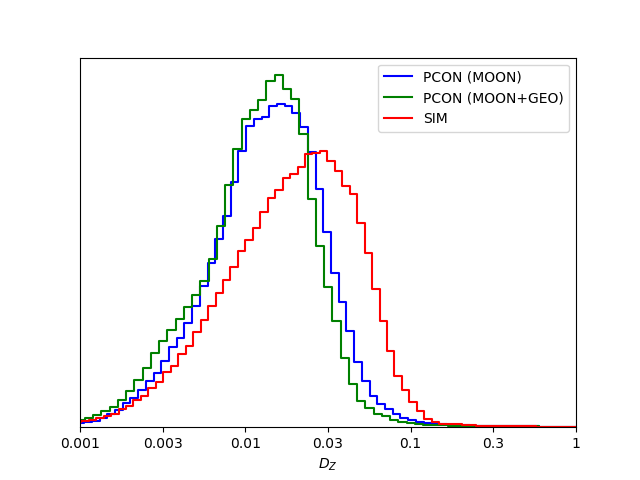

In [386]:
fig=plt.figure()
ax=fig.gca()

hp,xp=medHistogram(np.log10(adata["DZpcon_moon"].values),bins=100,density=True)
hpg,xpg=medHistogram(np.log10(adata["DZpcon_geomoon"].values),bins=100,density=True)
hs,xs=medHistogram(np.log10(adata["DZsim"].values),bins=100,density=True)

ax.step(xp,hp,color='b',label="PCON (MOON)")
ax.step(xpg,hpg,color='g',label="PCON (MOON+GEO)")
ax.step(xs,hs,color='r',label="SIM")

ax.set_xlabel(r"$D_Z$")

xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.set_xlim((-3,0))
ax.set_ylim((0,ymax))

xts=ax.get_xticks()
xtl=[]
for xt in xts:
    xtl+=[f"{10**xt:.1g}"]
ax.set_xticklabels(xtl)
ax.set_yticks([])

ax.legend(loc='upper right')

fig.savefig(f"{FIGDIR}/fig-compare_NUM_SIM_PCON_MOON.png")

In [404]:
stack=np.transpose(np.vstack((xp,hp,xpg,hpg,xs,hs)))
np.savetxt(f"{BDIR}/../grt-YearTestMoon/grtstat.data",stack)

In [409]:
stack[:,3]

array([5.48839030e-05, 0.00000000e+00, 0.00000000e+00, 5.48839030e-05,
       5.48839030e-05, 5.48839030e-05, 0.00000000e+00, 0.00000000e+00,
       5.48839030e-05, 1.09767806e-04, 1.09767806e-04, 2.19535612e-04,
       1.64651709e-04, 2.19535612e-04, 6.03722933e-04, 4.93955127e-04,
       5.48839030e-04, 6.58606836e-04, 1.20744587e-03, 2.03070441e-03,
       1.97582051e-03, 2.74419515e-03, 3.56745369e-03, 5.21397078e-03,
       6.58606836e-03, 8.61677277e-03, 1.35563240e-02, 1.56967962e-02,
       1.95386695e-02, 2.62345056e-02, 3.55098852e-02, 4.58280590e-02,
       5.88904279e-02, 7.65630446e-02, 1.02358479e-01, 1.32709277e-01,
       1.75628490e-01, 2.21017477e-01, 2.73870676e-01, 3.19863387e-01,
       3.60148171e-01, 4.00926911e-01, 4.46261015e-01, 4.90881628e-01,
       5.42966452e-01, 6.25347190e-01, 7.47628526e-01, 8.97845769e-01,
       1.03137830e+00, 1.14164007e+00, 1.17813786e+00, 1.21315379e+00,
       1.28560054e+00, 1.30568805e+00, 1.25607300e+00, 1.21836776e+00,
      

In [401]:
stack.shape

(100, 6)

<IPython.core.display.Javascript object>


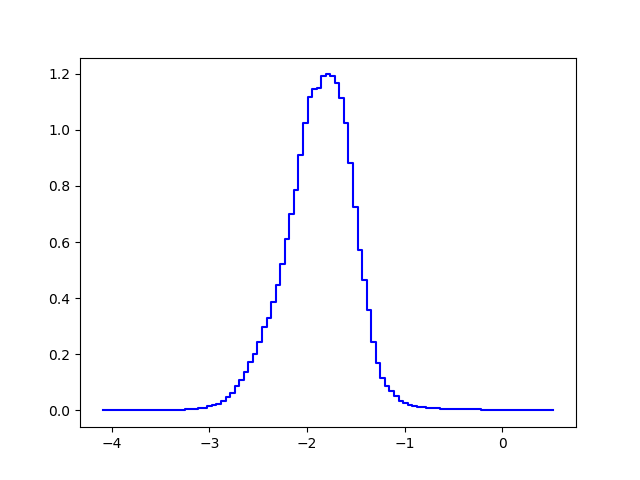

In [403]:
fig=plt.figure()
ax=fig.gca()

ax.step(stack[:,0],stack[:,1],color='b',label="PCON (MOON)")